### Run the classification on source extracted background

Compared to the star background (used as true detections)

Two techniques: Random forest classifier, and neural network implemented here with balanced and unbalanced data

In [1]:
# 
import sys
sys.path.append("../utils/")
from utils_ML import *
from util_event_files import HRCevt1
import numpy as np
from hyperscreen import hypercore, hypercore_csv, hypercore_stowed



/Users/beckynevin/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


compiled


In [2]:
# Look at the source versus background events:

# First load them up
file_dir = "/Users/beckynevin/CfA_Code/EVE/data/csv_files/"
obsid_train = '579'

bg_train = pd.read_csv(file_dir+'science_dataframe_cutout_'+str(obsid_train)+'.csv')
source_train = pd.read_csv(file_dir+'science_dataframe_stars_'+str(obsid_train)+'.csv')

# This is the science observation, or the two things above combined
obs = hypercore_csv.HRCevt1(file_dir+'science_dataframe_'+str(obsid_train)+'.csv')

/Users/beckynevin/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [26]:
print(bg_train[['time','x','y','av1','av2','av3','au1','au2','au3','fp_u','fb_u','fp_v','fb_v','pha','sumamps']])

                 time           x           y    av1     av2    av3    au1  \
0        6.087923e+07  21461.2660  14945.2970   12.0   480.0  408.0  320.0   
1        6.087923e+07  17277.4450  12790.1390  116.0   331.0   37.0  322.0   
2        6.087923e+07  15881.1130   9468.0625   62.0   488.0  209.0   44.0   
3        6.087923e+07  20402.5660  18611.3260   62.0   338.0  285.0  256.0   
4        6.087923e+07  21141.5800  17253.0900  116.0   522.0   33.0   46.0   
...               ...         ...         ...    ...     ...    ...    ...   
4687841  6.098367e+07  19619.2830  11515.8230   71.0   624.0  134.0  276.0   
4687842  6.098367e+07  19631.5040  12134.7980  152.0  1592.0  217.0   34.0   
4687843  6.098367e+07  16063.9375  16746.5300    8.0    11.0  242.0    1.0   
4687844  6.098367e+07  16997.0490   9104.4060   22.0   464.0  293.0   13.0   
4687845  6.098367e+07   8179.3590  16744.5230  101.0   540.0  252.0  288.0   

            au2    au3      fp_u      fb_u   pha  sumamps  
0  

In [4]:
def compare_in_parameter_space(param_list, df1, df2):
    print('~~~~~~~~Length of background = ', len(df1))
    print('~~~~~~~~Length of sources = ', len(df2))
    
    # Plot up x and y histograms for each of these as well so what they look like in x and y space
    plot_from_df(df1, 'Background', 'x', 'y')
    plot_from_df(df2, 'Sources', 'x', 'y')
    for j in range(int(len(param_list)/2)):
        xs_1 = df1[param_list[int(2*j)]].values
        ys_1 = df1[param_list[int(2*j+1)]].values
        
        xs_2 = df2[param_list[int(2*j)]].values
        ys_2 = df2[param_list[int(2*j+1)]].values
        
        plt.clf()
        plt.scatter(xs_1, ys_1, label='Background', s=1)
        plt.scatter(xs_2, ys_2, label='Sources', s=1)
        plt.legend()
        plt.xlabel(param_list[int(2*j)])
        plt.ylabel(param_list[int(2*j+1)])
        plt.show()
    

~~~~~~~~Length of background =  4687846
~~~~~~~~Length of sources =  47785


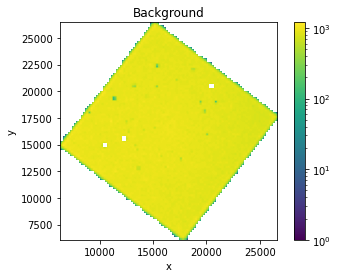

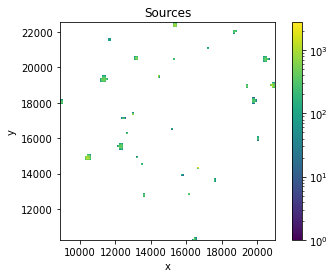

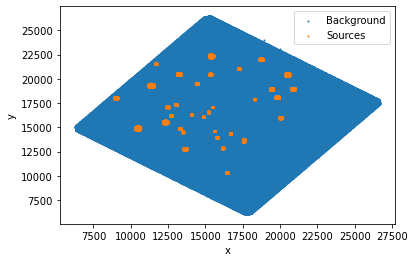

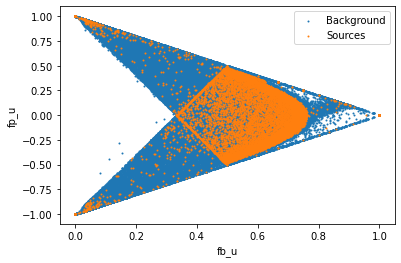

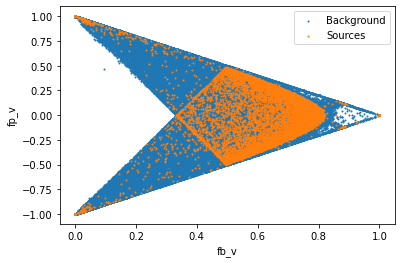

/Users/beckynevin/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


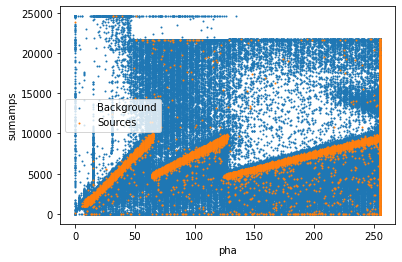

In [145]:
param_list = ['x','y','fb_u', 'fp_u', 'fb_v', 'fp_v', 'pha', 'sumamps']
compare_in_parameter_space(param_list, bg_train, source_train)


In [5]:
# Run a simple random forest:

# First, make class labels
bg_train['class'] = 1
source_train['class'] = 0

# Then combine everything together into one 'X':
X = pd.concat([bg_train, source_train])

# Make a random number column:

random_numbers = np.random.random(size=len(X))

X['random'] = random_numbers

print(X.columns)

Index(['Unnamed: 0', 'time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety',
       'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u',
       'fb_u', 'fp_v', 'fb_v', 'AV3 corrected for ringing',
       'AU3 corrected for ringing', 'Event impacted by prior event (piled up)',
       'Shifted event time', 'Event telemetered in NIL mode',
       'V axis not triggered', 'U axis not triggered',
       'V axis center blank event', 'U axis center blank event',
       'V axis width exceeded', 'U axis width exceeded', 'Shield PMT active',
       'Upper level discriminator not exceeded',
       'Lower level discriminator not exceeded', 'Event in bad region',
       'Amp total on V or U = 0', 'Incorrect V center', 'Incorrect U center',
       'PHA ratio test failed', 'Sum of 6 taps = 0', 'Grid ratio test failed',
       'ADC sum on V or U = 0', 'PI exceeding 255',
       'Event time tag is out of seque

../utils/utils_ML.py:127: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_features, train_labels)


[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1


<Figure size 432x288 with 0 Axes>

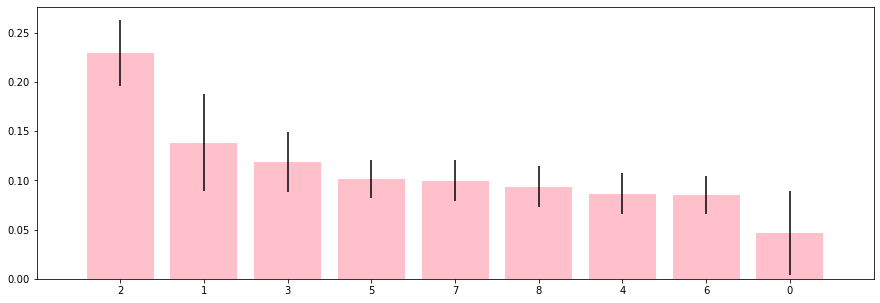

Importance in Order ~~~~
random idx 8
random_value 0.09352686723977684
2 pi
1 pha
3 sumamps
5 fb_u
7 fb_v
8 random
4 fp_u
6 fp_v
0 amp_sf


In [6]:
# Get rid of nans:


# Decide which features you are going to use for the random forest:

feature_list_RFC_no_class = ['amp_sf','pha','pi','sumamps',
                    'fp_u','fb_u','fp_v','fb_v','random']
feature_list_RFC = ['amp_sf','pha','pi','sumamps',
                    'fp_u','fb_u','fp_v','fb_v','random','class']
run_features_RFC = X[feature_list_RFC]
df_RFC = run_features_RFC.dropna()
terms_RFC, reject_terms_RFC, model_RFC = run_RFC(df_RFC, feature_list_RFC_no_class, 'yes')


In [8]:
df_dropna = X[feature_list_RFC].dropna()
ys = df_dropna['class']
Xs = df_dropna[feature_list_RFC_no_class]


acc_random_forest = round(model_RFC.score(Xs, ys) * 100, 2) 
print('Accuracy of the random forest', acc_random_forest)
# So every so slightly beter than normal

Accuracy of the random forest 99.0


../utils/utils_ML.py:127: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_features, train_labels)


[1] 1
[1] 0
[1] 1
[1] 1
[1] 1
[1] 0
[1] 1
[1] 0
[1] 0
[1] 0


<Figure size 432x288 with 0 Axes>

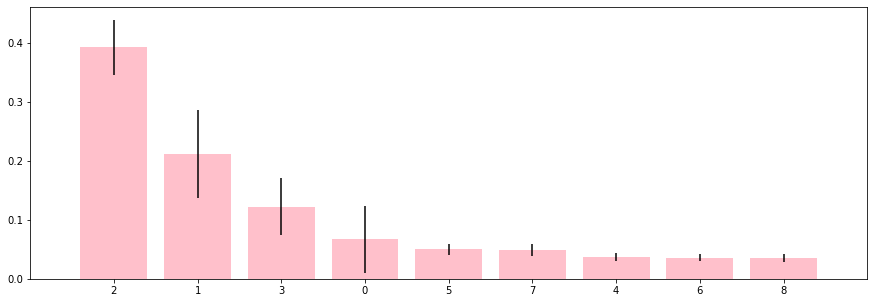

Importance in Order ~~~~
random idx 8
random_value 0.03559465225070639
2 pi
1 pha
3 sumamps
0 amp_sf
5 fb_u
7 fb_v
4 fp_u
6 fp_v
8 random
Accuracy of the random forest 66.16


In [12]:
# Same thing but rebalance the classes:
df_dropna_RF = balance_classes(bg_train, source_train,1)
# Add back in random numbers:
random_numbers = np.random.random(size=len(df_dropna_RF))
df_dropna_RF['random'] = random_numbers

run_features_RFC = df_dropna_RF[feature_list_RFC]
df_RFC = run_features_RFC.dropna()
terms_RFC_b, reject_terms_RFC_b, model_RFC_b = run_RFC(df_RFC, feature_list_RFC_no_class, 'yes')
df_dropna = df_dropna_RF[feature_list_RFC].dropna()
ys = df_dropna['class']
Xs = df_dropna[feature_list_RFC_no_class]


acc_random_forest = round(model_RFC_b.score(Xs, ys) * 100, 2) 
print('Accuracy of the random forest', acc_random_forest)

In [17]:
# Apply this to the example plz

cas_A = pd.read_csv(file_dir+'science_dataframe_1505.csv').dropna()

random_numbers = np.random.random(size=len(cas_A))
cas_A['random'] = random_numbers
# Add a random number:

Xs = np.array(cas_A[feature_list_RFC_no_class].values)

predict_cas_A = model_RFC_b.predict(Xs)

~~~~~~~~Length of background =  3661110
~~~~~~~~Length of sources =  3239393


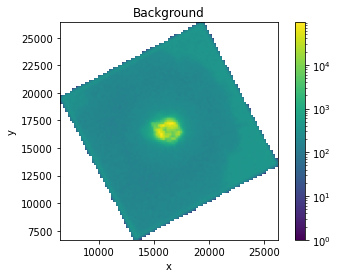

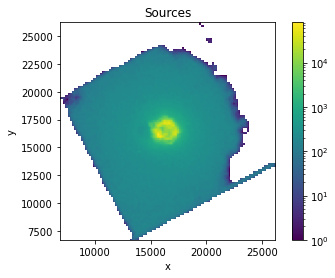

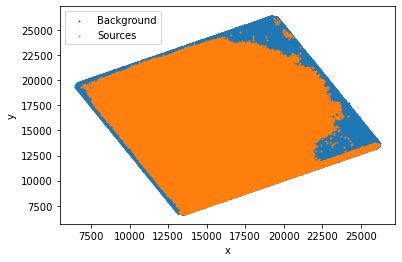

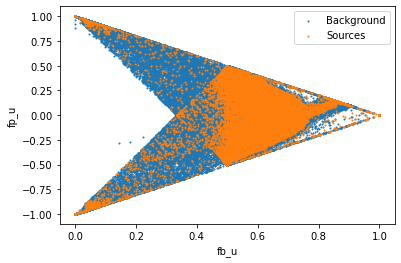

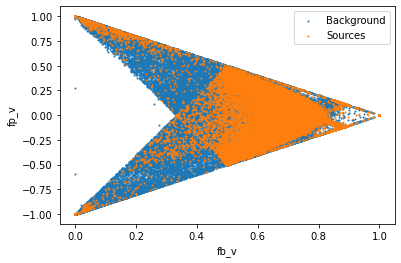

/Users/beckynevin/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


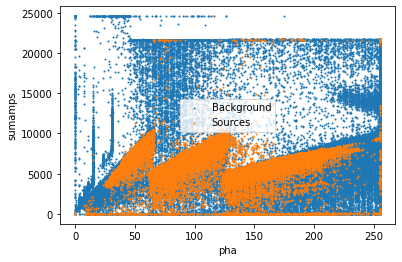

In [19]:
cas_A['prediction'] = predict_cas_A


df1 = cas_A[cas_A['prediction'] > 0.5]
df2 = cas_A[cas_A['prediction'] < 0.5]

param_list = ['x','y','fb_u', 'fp_u', 'fb_v', 'fp_v', 'pha', 'sumamps']

compare_in_parameter_space(param_list, df1, df2)

~~~~~~~~Length of background =  1340703
~~~~~~~~Length of sources =  2423


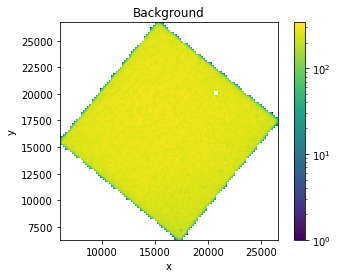

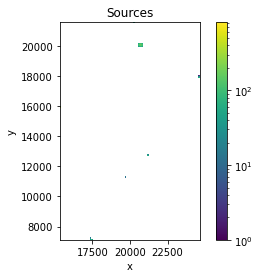

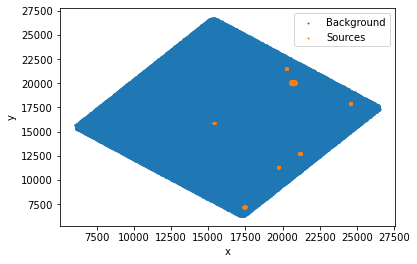

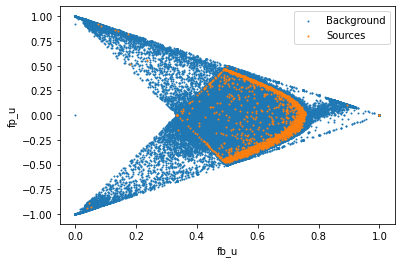

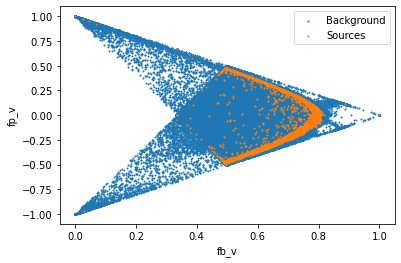

/Users/beckynevin/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


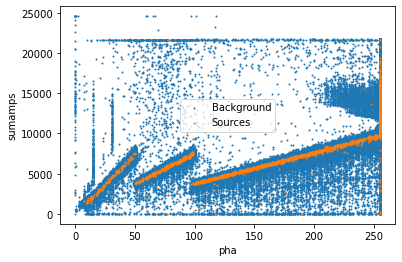

~~~~~~~~Length of background =  895979
~~~~~~~~Length of sources =  447135


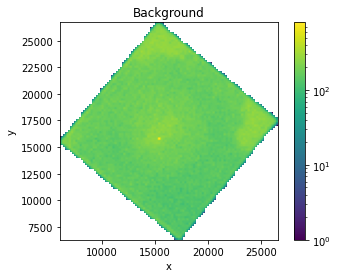

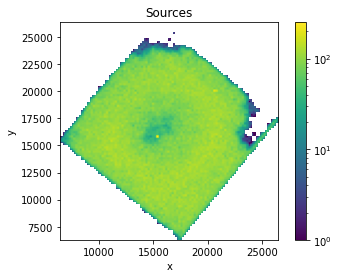

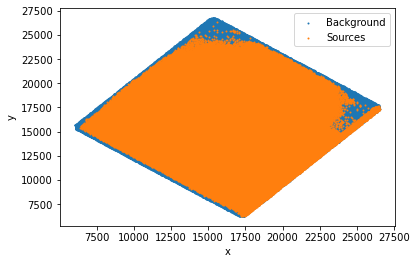

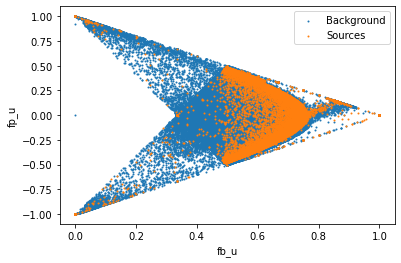

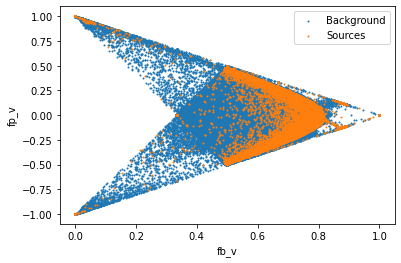

/Users/beckynevin/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


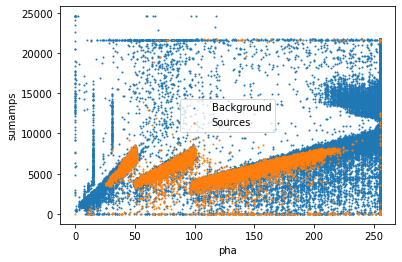

In [24]:
# Can also test on another exposure of the lockman hole, 301
obsid_test = '1291'

bg_test = pd.read_csv(file_dir+'science_dataframe_cutout_'+str(obsid_test)+'.csv')
source_test = pd.read_csv(file_dir+'science_dataframe_stars_'+str(obsid_test)+'.csv')

param_list = ['x','y','fb_u', 'fp_u', 'fb_v', 'fp_v', 'pha', 'sumamps']

compare_in_parameter_space(param_list, bg_test, source_test)

bg_test['class'] = 1
source_test['class'] = 0

# combine into 1

test_combo = pd.concat([bg_test, source_test]).dropna()

random_numbers = np.random.random(size=len(test_combo))
test_combo['random'] = random_numbers
# Add a random number:

Xs = np.array(test_combo[feature_list_RFC_no_class].values)

predict_test_combo = model_RFC_b.predict(Xs)

test_combo['prediction'] = predict_test_combo


df1 = test_combo[test_combo['prediction'] > 0.5]
df2 = test_combo[test_combo['prediction'] < 0.5]

param_list = ['x','y','fb_u', 'fp_u', 'fb_v', 'fp_v', 'pha', 'sumamps']

compare_in_parameter_space(param_list, df1, df2)

In [ ]:
# Might need a conditional random forest if you want to deal with categorical variables
# Apparently another method to use is one hot encoding

In [26]:
# Setting up a neural network:
# create NeuralNetwork class
class NeuralNetwork:

    # intialize variables in class
    def __init__(self, inputs, outputs):
        self.inputs  = inputs
        self.outputs = outputs
        # initialize weights as .50 for simplicity
        self.weights = 0.50*np.ones(np.shape(inputs)[1])
        #np.array([[.50], [.50], [.50]])
        self.error_history = []
        self.epoch_list = []

    #activation function ==> S(x) = 1/1+e^(-x)
    def sigmoid(self, x, deriv=False):
        if deriv == True:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    # data will flow through the neural network.
    def feed_forward(self):
        self.hidden = self.sigmoid(np.dot(self.inputs, self.weights))

    # going backwards through the network to update weights
    def backpropagation(self):
        self.error  = self.outputs - self.hidden
        delta = self.error * self.sigmoid(self.hidden, deriv=True)
        self.weights += np.dot(self.inputs.T, delta)

    # train the neural net for 25,000 iterations
    def train(self, epochs=200):
        for epoch in range(epochs):
            # flow forward and produce an output
            self.feed_forward()
            # go back though the network to make corrections based on the output
            self.backpropagation()    
            # keep track of the error history over each epoch
            self.error_history.append(np.average(np.abs(self.error)))
            self.epoch_list.append(epoch)

    # function to predict output on new and unseen input data                               
    def predict(self, new_input):
        prediction = self.sigmoid(np.dot(new_input, self.weights))
        return prediction


In [69]:
# create neural network

'''
feature_list = ['crsv','crsu','amp_sf','x','y','pha','pi','sumamps',
                    'fp_u','fb_u','fp_v','fb_v']
Xs = np.array(X[feature_list].values)
y = X['class'].values
ys = y.reshape((len(X),1))

'''

'''
print(inputs)
print(outputs)

print(np.shape(inputs), np.shape(outputs))


inputs = np.array([[0, 1, 0],
                   [0, 1, 1],
                   [0, 0, 0],
                   [1, 0, 0],
                   [1, 1, 1],
                   [1, 0, 1]])
# output data
outputs = np.array([[0], [0], [0], [1], [1], [1]])

print(inputs)
print(outputs)

print(np.shape(inputs), np.shape(outputs))

STOP

NN = NeuralNetwork(inputs, outputs)
# train neural network
NN.train()
'''


In [70]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 12)                768       
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 9         
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


In [10]:
def balance_classes(df1, df2, ratio):
    # Assign class labels
    df1['class'] = 1 #background
    df2['class'] = 0 #source
    
    len_bg = ratio*len(df2)
    
    df1_sampled = df1.sample(n=len_bg, random_state=1)
    
    
    
    # Now concat them together:
    return  pd.concat([df1_sampled,df2]).dropna()
    
    
    

In [136]:
## Run a neural network but first balance the classes:
df_dropna = balance_classes(bg_train, source_train,1)
# First, make class labels


#'crsv','crsu','amp_sf','x','y',
feature_list = ['fp_u','fb_u','fp_v','fb_v']

Xs = np.array(df_dropna[feature_list].values)

ys = (df_dropna['class'].values).reshape((len(df_dropna),1))

print(np.shape(Xs), np.shape(ys))

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=np.shape(Xs)[1], activation='relu'))
model.add(Dense(8, activation='relu'))
#model.add(Dense(2, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Okay but we need a validation set plz:
idx = np.random.choice(np.arange(len(Xs)), int(0.2*len(Xs)), replace=False)

import random

def choice(N, percent):
    tmp = np.arange(N)
    random.shuffle(tmp)
    cut = int(N * percent)
    return tmp[:cut], tmp[cut:]

valid_idx, train_idx = choice(len(Xs),0.2)

print('len valid', len(valid_idx), 'len train', len(train_idx))


Xs_train = Xs[train_idx]
ys_train = ys[train_idx]

Xs_valid = Xs[valid_idx]
ys_valid = ys[valid_idx]


# The other option is to shuffle and then use the validation_split keyword:
index_split = np.arange(len(Xs))
random.shuffle(index_split)
Xs_shuffled = Xs[index_split]
ys_shuffled = ys[index_split]

history = model.fit(Xs_shuffled, ys_shuffled, validation_split=0.1, epochs=1000, batch_size=64, verbose=True)

(94899, 7) (94899, 1)
len valid 18979 len train 75920
Train on 85409 samples, validate on 9490 samples
Epoch 1/1000
85409/85409 [==============================] - ETA: 14:26 - loss: 989.5201 - accuracy: 0.484 - ETA: 28s - loss: 548.1758 - accuracy: 0.4814  - ETA: 14s - loss: 292.1269 - accuracy: 0.497 - ETA: 9s - loss: 191.2839 - accuracy: 0.488 - ETA: 7s - loss: 144.4951 - accuracy: 0.49 - ETA: 6s - loss: 115.9397 - accuracy: 0.48 - ETA: 5s - loss: 96.5001 - accuracy: 0.4873 - ETA: 4s - loss: 83.7310 - accuracy: 0.487 - ETA: 4s - loss: 73.5542 - accuracy: 0.485 - ETA: 3s - loss: 65.4744 - accuracy: 0.485 - ETA: 3s - loss: 59.3468 - accuracy: 0.485 - ETA: 3s - loss: 54.0640 - accuracy: 0.486 - ETA: 2s - loss: 50.0804 - accuracy: 0.485 - ETA: 2s - loss: 46.8944 - accuracy: 0.485 - ETA: 2s - loss: 43.9386 - accuracy: 0.485 - ETA: 2s - loss: 41.2796 - accuracy: 0.485 - ETA: 2s - loss: 38.8371 - accuracy: 0.484 - ETA: 1s - loss: 36.7839 - accuracy: 0.483 - ETA: 1s - loss: 34.9496 - accurac

85409/85409 [==============================] - ETA: 3s - loss: 0.6987 - accuracy: 0.54 - ETA: 2s - loss: 1.3457 - accuracy: 0.49 - ETA: 2s - loss: 1.8288 - accuracy: 0.50 - ETA: 2s - loss: 1.7558 - accuracy: 0.50 - ETA: 1s - loss: 2.6188 - accuracy: 0.49 - ETA: 1s - loss: 2.6044 - accuracy: 0.49 - ETA: 1s - loss: 2.5237 - accuracy: 0.49 - ETA: 1s - loss: 2.9774 - accuracy: 0.50 - ETA: 1s - loss: 3.1225 - accuracy: 0.50 - ETA: 1s - loss: 3.0105 - accuracy: 0.50 - ETA: 1s - loss: 2.8528 - accuracy: 0.49 - ETA: 1s - loss: 2.7768 - accuracy: 0.49 - ETA: 1s - loss: 2.8005 - accuracy: 0.49 - ETA: 1s - loss: 2.7207 - accuracy: 0.49 - ETA: 1s - loss: 2.6208 - accuracy: 0.49 - ETA: 1s - loss: 2.5084 - accuracy: 0.50 - ETA: 1s - loss: 2.4207 - accuracy: 0.49 - ETA: 1s - loss: 2.4915 - accuracy: 0.50 - ETA: 1s - loss: 2.7018 - accuracy: 0.50 - ETA: 1s - loss: 2.7298 - accuracy: 0.50 - ETA: 1s - loss: 2.7050 - accuracy: 0.50 - ETA: 1s - loss: 2.7066 - accuracy: 0.49 - ETA: 0s - loss: 2.7889 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6928 - accuracy: 0.54 - ETA: 1s - loss: 2.7982 - accuracy: 0.49 - ETA: 1s - loss: 2.2121 - accuracy: 0.49 - ETA: 1s - loss: 2.3783 - accuracy: 0.50 - ETA: 1s - loss: 2.2285 - accuracy: 0.50 - ETA: 1s - loss: 2.0800 - accuracy: 0.50 - ETA: 2s - loss: 2.0279 - accuracy: 0.50 - ETA: 2s - loss: 2.0020 - accuracy: 0.50 - ETA: 2s - loss: 1.9930 - accuracy: 0.50 - ETA: 2s - loss: 2.1399 - accuracy: 0.50 - ETA: 2s - loss: 2.4754 - accuracy: 0.50 - ETA: 2s - loss: 2.7236 - accuracy: 0.50 - ETA: 1s - loss: 2.7603 - accuracy: 0.50 - ETA: 1s - loss: 2.8085 - accuracy: 0.50 - ETA: 1s - loss: 2.7810 - accuracy: 0.50 - ETA: 1s - loss: 2.8517 - accuracy: 0.49 - ETA: 1s - loss: 2.7593 - accuracy: 0.49 - ETA: 1s - loss: 2.6949 - accuracy: 0.49 - ETA: 1s - loss: 2.6355 - accuracy: 0.49 - ETA: 1s - loss: 2.5647 - accuracy: 0.49 - ETA: 1s - loss: 2.5235 - accuracy: 0.49 - ETA: 1s - loss: 2.4856 - accuracy: 0.49 - ETA: 1s - loss: 2.4565 - accu

85409/85409 [==============================] - ETA: 4s - loss: 4.0128 - accuracy: 0.48 - ETA: 4s - loss: 2.9963 - accuracy: 0.51 - ETA: 3s - loss: 1.6407 - accuracy: 0.51 - ETA: 2s - loss: 1.6952 - accuracy: 0.50 - ETA: 2s - loss: 1.4883 - accuracy: 0.50 - ETA: 2s - loss: 1.4994 - accuracy: 0.50 - ETA: 2s - loss: 1.5824 - accuracy: 0.50 - ETA: 2s - loss: 1.5344 - accuracy: 0.50 - ETA: 2s - loss: 1.5036 - accuracy: 0.50 - ETA: 2s - loss: 1.4590 - accuracy: 0.50 - ETA: 1s - loss: 1.5501 - accuracy: 0.50 - ETA: 1s - loss: 1.5079 - accuracy: 0.50 - ETA: 1s - loss: 1.5051 - accuracy: 0.50 - ETA: 1s - loss: 1.5736 - accuracy: 0.50 - ETA: 1s - loss: 1.5858 - accuracy: 0.50 - ETA: 1s - loss: 1.6532 - accuracy: 0.50 - ETA: 1s - loss: 1.6023 - accuracy: 0.50 - ETA: 1s - loss: 1.6516 - accuracy: 0.50 - ETA: 1s - loss: 1.6429 - accuracy: 0.50 - ETA: 1s - loss: 1.6410 - accuracy: 0.50 - ETA: 1s - loss: 1.6143 - accuracy: 0.50 - ETA: 1s - loss: 1.6017 - accuracy: 0.50 - ETA: 1s - loss: 1.5914 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.7124 - accuracy: 0.53 - ETA: 1s - loss: 1.6591 - accuracy: 0.49 - ETA: 1s - loss: 1.5306 - accuracy: 0.50 - ETA: 1s - loss: 1.7400 - accuracy: 0.49 - ETA: 1s - loss: 2.4067 - accuracy: 0.50 - ETA: 1s - loss: 2.3964 - accuracy: 0.49 - ETA: 1s - loss: 2.1859 - accuracy: 0.49 - ETA: 1s - loss: 2.0359 - accuracy: 0.49 - ETA: 1s - loss: 1.8822 - accuracy: 0.50 - ETA: 1s - loss: 1.7839 - accuracy: 0.50 - ETA: 1s - loss: 1.6943 - accuracy: 0.50 - ETA: 1s - loss: 1.6510 - accuracy: 0.50 - ETA: 1s - loss: 1.7036 - accuracy: 0.50 - ETA: 1s - loss: 1.7623 - accuracy: 0.50 - ETA: 1s - loss: 1.8105 - accuracy: 0.50 - ETA: 1s - loss: 1.7708 - accuracy: 0.50 - ETA: 1s - loss: 1.7185 - accuracy: 0.50 - ETA: 1s - loss: 1.6961 - accuracy: 0.50 - ETA: 0s - loss: 1.6822 - accuracy: 0.50 - ETA: 0s - loss: 1.6649 - accuracy: 0.50 - ETA: 0s - loss: 1.6739 - accuracy: 0.50 - ETA: 0s - loss: 1.6663 - accuracy: 0.50 - ETA: 0s - loss: 1.6392 - accu

85409/85409 [==============================] - ETA: 3s - loss: 1.9222 - accuracy: 0.40 - ETA: 1s - loss: 1.2742 - accuracy: 0.50 - ETA: 1s - loss: 1.2514 - accuracy: 0.49 - ETA: 1s - loss: 1.3079 - accuracy: 0.50 - ETA: 1s - loss: 1.5776 - accuracy: 0.50 - ETA: 1s - loss: 1.5814 - accuracy: 0.50 - ETA: 1s - loss: 1.5911 - accuracy: 0.50 - ETA: 1s - loss: 1.5130 - accuracy: 0.50 - ETA: 1s - loss: 1.6241 - accuracy: 0.50 - ETA: 1s - loss: 1.5618 - accuracy: 0.50 - ETA: 1s - loss: 1.5226 - accuracy: 0.50 - ETA: 1s - loss: 1.5978 - accuracy: 0.50 - ETA: 1s - loss: 1.5697 - accuracy: 0.50 - ETA: 1s - loss: 1.5281 - accuracy: 0.50 - ETA: 1s - loss: 1.4788 - accuracy: 0.50 - ETA: 1s - loss: 1.4485 - accuracy: 0.50 - ETA: 1s - loss: 1.4518 - accuracy: 0.50 - ETA: 0s - loss: 1.4277 - accuracy: 0.50 - ETA: 0s - loss: 1.4081 - accuracy: 0.50 - ETA: 0s - loss: 1.3990 - accuracy: 0.50 - ETA: 0s - loss: 1.4386 - accuracy: 0.50 - ETA: 0s - loss: 1.5403 - accuracy: 0.50 - ETA: 0s - loss: 1.5270 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6818 - accuracy: 0.56 - ETA: 1s - loss: 1.5613 - accuracy: 0.51 - ETA: 1s - loss: 1.5033 - accuracy: 0.50 - ETA: 1s - loss: 1.5451 - accuracy: 0.50 - ETA: 1s - loss: 1.3680 - accuracy: 0.50 - ETA: 1s - loss: 1.3412 - accuracy: 0.50 - ETA: 1s - loss: 1.4441 - accuracy: 0.50 - ETA: 1s - loss: 1.4262 - accuracy: 0.50 - ETA: 1s - loss: 1.3644 - accuracy: 0.50 - ETA: 1s - loss: 1.3393 - accuracy: 0.50 - ETA: 1s - loss: 1.3159 - accuracy: 0.50 - ETA: 1s - loss: 1.3408 - accuracy: 0.50 - ETA: 1s - loss: 1.3387 - accuracy: 0.50 - ETA: 1s - loss: 1.3093 - accuracy: 0.50 - ETA: 1s - loss: 1.3349 - accuracy: 0.50 - ETA: 1s - loss: 1.3261 - accuracy: 0.50 - ETA: 1s - loss: 1.3657 - accuracy: 0.50 - ETA: 0s - loss: 1.3445 - accuracy: 0.50 - ETA: 0s - loss: 1.3558 - accuracy: 0.50 - ETA: 0s - loss: 1.4603 - accuracy: 0.50 - ETA: 0s - loss: 1.5202 - accuracy: 0.50 - ETA: 0s - loss: 1.5495 - accuracy: 0.50 - ETA: 0s - loss: 1.5255 - accu

85409/85409 [==============================] - ETA: 3s - loss: 1.0733 - accuracy: 0.54 - ETA: 1s - loss: 0.9655 - accuracy: 0.50 - ETA: 1s - loss: 0.9297 - accuracy: 0.50 - ETA: 1s - loss: 0.9358 - accuracy: 0.50 - ETA: 1s - loss: 0.9756 - accuracy: 0.50 - ETA: 1s - loss: 1.0704 - accuracy: 0.50 - ETA: 1s - loss: 1.1501 - accuracy: 0.50 - ETA: 1s - loss: 1.1607 - accuracy: 0.50 - ETA: 1s - loss: 1.1956 - accuracy: 0.50 - ETA: 1s - loss: 1.1728 - accuracy: 0.50 - ETA: 1s - loss: 1.2413 - accuracy: 0.50 - ETA: 1s - loss: 1.3200 - accuracy: 0.50 - ETA: 1s - loss: 1.3364 - accuracy: 0.50 - ETA: 1s - loss: 1.3032 - accuracy: 0.50 - ETA: 1s - loss: 1.2757 - accuracy: 0.50 - ETA: 1s - loss: 1.2654 - accuracy: 0.50 - ETA: 1s - loss: 1.2630 - accuracy: 0.50 - ETA: 0s - loss: 1.2670 - accuracy: 0.50 - ETA: 0s - loss: 1.2742 - accuracy: 0.50 - ETA: 0s - loss: 1.2961 - accuracy: 0.50 - ETA: 0s - loss: 1.3075 - accuracy: 0.50 - ETA: 0s - loss: 1.3030 - accuracy: 0.50 - ETA: 0s - loss: 1.3296 - accu

85409/85409 [==============================] - ETA: 3s - loss: 2.4241 - accuracy: 0.50 - ETA: 1s - loss: 1.5609 - accuracy: 0.49 - ETA: 1s - loss: 1.1887 - accuracy: 0.50 - ETA: 1s - loss: 1.1193 - accuracy: 0.51 - ETA: 1s - loss: 1.1162 - accuracy: 0.51 - ETA: 1s - loss: 1.0673 - accuracy: 0.51 - ETA: 1s - loss: 1.0561 - accuracy: 0.51 - ETA: 1s - loss: 1.0480 - accuracy: 0.50 - ETA: 1s - loss: 1.0286 - accuracy: 0.51 - ETA: 1s - loss: 1.0017 - accuracy: 0.51 - ETA: 1s - loss: 1.0280 - accuracy: 0.50 - ETA: 1s - loss: 1.1398 - accuracy: 0.50 - ETA: 1s - loss: 1.1537 - accuracy: 0.50 - ETA: 1s - loss: 1.2793 - accuracy: 0.50 - ETA: 1s - loss: 1.2760 - accuracy: 0.50 - ETA: 1s - loss: 1.2599 - accuracy: 0.50 - ETA: 1s - loss: 1.2393 - accuracy: 0.50 - ETA: 1s - loss: 1.2171 - accuracy: 0.50 - ETA: 0s - loss: 1.2044 - accuracy: 0.50 - ETA: 0s - loss: 1.1936 - accuracy: 0.50 - ETA: 0s - loss: 1.1900 - accuracy: 0.51 - ETA: 0s - loss: 1.1851 - accuracy: 0.50 - ETA: 0s - loss: 1.1732 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.7911 - accuracy: 0.56 - ETA: 1s - loss: 0.8018 - accuracy: 0.52 - ETA: 1s - loss: 0.9564 - accuracy: 0.51 - ETA: 1s - loss: 0.9170 - accuracy: 0.51 - ETA: 1s - loss: 0.9439 - accuracy: 0.51 - ETA: 1s - loss: 0.9464 - accuracy: 0.51 - ETA: 1s - loss: 0.9505 - accuracy: 0.51 - ETA: 1s - loss: 0.9609 - accuracy: 0.51 - ETA: 1s - loss: 0.9440 - accuracy: 0.51 - ETA: 1s - loss: 0.9948 - accuracy: 0.51 - ETA: 1s - loss: 0.9871 - accuracy: 0.51 - ETA: 1s - loss: 0.9887 - accuracy: 0.51 - ETA: 1s - loss: 0.9976 - accuracy: 0.51 - ETA: 1s - loss: 1.0014 - accuracy: 0.51 - ETA: 1s - loss: 0.9860 - accuracy: 0.51 - ETA: 1s - loss: 0.9750 - accuracy: 0.51 - ETA: 1s - loss: 1.0267 - accuracy: 0.51 - ETA: 0s - loss: 1.0746 - accuracy: 0.51 - ETA: 0s - loss: 1.0861 - accuracy: 0.51 - ETA: 0s - loss: 1.0795 - accuracy: 0.51 - ETA: 0s - loss: 1.0675 - accuracy: 0.51 - ETA: 0s - loss: 1.0605 - accuracy: 0.51 - ETA: 0s - loss: 1.0986 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6941 - accuracy: 0.54 - ETA: 1s - loss: 0.7732 - accuracy: 0.53 - ETA: 1s - loss: 0.7926 - accuracy: 0.51 - ETA: 1s - loss: 0.7881 - accuracy: 0.52 - ETA: 1s - loss: 0.8684 - accuracy: 0.51 - ETA: 1s - loss: 0.9370 - accuracy: 0.51 - ETA: 1s - loss: 1.0027 - accuracy: 0.51 - ETA: 1s - loss: 1.0225 - accuracy: 0.51 - ETA: 1s - loss: 1.0094 - accuracy: 0.51 - ETA: 1s - loss: 1.0094 - accuracy: 0.51 - ETA: 1s - loss: 1.0091 - accuracy: 0.51 - ETA: 1s - loss: 0.9936 - accuracy: 0.51 - ETA: 1s - loss: 1.0012 - accuracy: 0.51 - ETA: 1s - loss: 0.9851 - accuracy: 0.51 - ETA: 1s - loss: 0.9773 - accuracy: 0.51 - ETA: 1s - loss: 0.9601 - accuracy: 0.51 - ETA: 1s - loss: 0.9537 - accuracy: 0.51 - ETA: 1s - loss: 0.9488 - accuracy: 0.51 - ETA: 1s - loss: 0.9471 - accuracy: 0.51 - ETA: 0s - loss: 0.9430 - accuracy: 0.51 - ETA: 0s - loss: 0.9401 - accuracy: 0.51 - ETA: 0s - loss: 0.9486 - accuracy: 0.51 - ETA: 0s - loss: 0.9495 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6550 - accuracy: 0.56 - ETA: 2s - loss: 0.9651 - accuracy: 0.51 - ETA: 1s - loss: 0.9158 - accuracy: 0.52 - ETA: 1s - loss: 0.9162 - accuracy: 0.51 - ETA: 1s - loss: 0.9884 - accuracy: 0.51 - ETA: 1s - loss: 0.9582 - accuracy: 0.51 - ETA: 1s - loss: 0.9421 - accuracy: 0.51 - ETA: 1s - loss: 0.9967 - accuracy: 0.51 - ETA: 1s - loss: 0.9750 - accuracy: 0.51 - ETA: 1s - loss: 0.9745 - accuracy: 0.51 - ETA: 1s - loss: 0.9911 - accuracy: 0.51 - ETA: 1s - loss: 0.9880 - accuracy: 0.51 - ETA: 1s - loss: 1.0434 - accuracy: 0.51 - ETA: 1s - loss: 1.0363 - accuracy: 0.51 - ETA: 1s - loss: 1.0311 - accuracy: 0.51 - ETA: 1s - loss: 1.0332 - accuracy: 0.51 - ETA: 1s - loss: 1.0206 - accuracy: 0.51 - ETA: 1s - loss: 1.0127 - accuracy: 0.51 - ETA: 1s - loss: 1.0025 - accuracy: 0.51 - ETA: 1s - loss: 1.0127 - accuracy: 0.51 - ETA: 0s - loss: 1.0161 - accuracy: 0.51 - ETA: 0s - loss: 1.0164 - accuracy: 0.51 - ETA: 0s - loss: 1.0040 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.7063 - accuracy: 0.57 - ETA: 1s - loss: 0.7689 - accuracy: 0.54 - ETA: 1s - loss: 0.7816 - accuracy: 0.55 - ETA: 1s - loss: 0.7570 - accuracy: 0.55 - ETA: 1s - loss: 0.7641 - accuracy: 0.55 - ETA: 1s - loss: 0.7657 - accuracy: 0.55 - ETA: 1s - loss: 0.8145 - accuracy: 0.54 - ETA: 1s - loss: 0.8178 - accuracy: 0.54 - ETA: 1s - loss: 0.8068 - accuracy: 0.55 - ETA: 1s - loss: 0.8331 - accuracy: 0.54 - ETA: 1s - loss: 0.8410 - accuracy: 0.54 - ETA: 1s - loss: 0.8421 - accuracy: 0.54 - ETA: 1s - loss: 0.8481 - accuracy: 0.54 - ETA: 1s - loss: 0.8629 - accuracy: 0.54 - ETA: 1s - loss: 0.8839 - accuracy: 0.54 - ETA: 1s - loss: 0.8810 - accuracy: 0.54 - ETA: 1s - loss: 0.8793 - accuracy: 0.54 - ETA: 1s - loss: 0.9052 - accuracy: 0.54 - ETA: 1s - loss: 0.9168 - accuracy: 0.54 - ETA: 1s - loss: 0.9112 - accuracy: 0.54 - ETA: 0s - loss: 0.9200 - accuracy: 0.54 - ETA: 0s - loss: 0.9160 - accuracy: 0.54 - ETA: 0s - loss: 0.9093 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6174 - accuracy: 0.64 - ETA: 2s - loss: 0.8469 - accuracy: 0.54 - ETA: 2s - loss: 0.8029 - accuracy: 0.55 - ETA: 2s - loss: 0.7829 - accuracy: 0.55 - ETA: 1s - loss: 0.7682 - accuracy: 0.55 - ETA: 1s - loss: 0.8042 - accuracy: 0.55 - ETA: 1s - loss: 0.8368 - accuracy: 0.54 - ETA: 1s - loss: 0.8438 - accuracy: 0.54 - ETA: 1s - loss: 0.8704 - accuracy: 0.54 - ETA: 1s - loss: 0.8498 - accuracy: 0.54 - ETA: 1s - loss: 0.8430 - accuracy: 0.54 - ETA: 1s - loss: 0.8390 - accuracy: 0.54 - ETA: 1s - loss: 0.8357 - accuracy: 0.54 - ETA: 1s - loss: 0.8317 - accuracy: 0.54 - ETA: 1s - loss: 0.8358 - accuracy: 0.54 - ETA: 1s - loss: 0.8377 - accuracy: 0.54 - ETA: 1s - loss: 0.8354 - accuracy: 0.54 - ETA: 1s - loss: 0.8292 - accuracy: 0.54 - ETA: 1s - loss: 0.8222 - accuracy: 0.55 - ETA: 1s - loss: 0.8193 - accuracy: 0.55 - ETA: 1s - loss: 0.8165 - accuracy: 0.55 - ETA: 0s - loss: 0.8225 - accuracy: 0.54 - ETA: 0s - loss: 0.8276 - accu

85409/85409 [==============================] - ETA: 3s - loss: 3.6352 - accuracy: 0.45 - ETA: 1s - loss: 1.5793 - accuracy: 0.52 - ETA: 1s - loss: 1.2539 - accuracy: 0.53 - ETA: 1s - loss: 1.1518 - accuracy: 0.53 - ETA: 1s - loss: 1.0592 - accuracy: 0.54 - ETA: 1s - loss: 0.9897 - accuracy: 0.54 - ETA: 1s - loss: 0.9751 - accuracy: 0.54 - ETA: 1s - loss: 0.9734 - accuracy: 0.54 - ETA: 1s - loss: 0.9498 - accuracy: 0.54 - ETA: 1s - loss: 0.9349 - accuracy: 0.54 - ETA: 1s - loss: 0.9238 - accuracy: 0.54 - ETA: 1s - loss: 0.9080 - accuracy: 0.54 - ETA: 1s - loss: 0.8947 - accuracy: 0.54 - ETA: 1s - loss: 0.8902 - accuracy: 0.54 - ETA: 1s - loss: 0.8832 - accuracy: 0.54 - ETA: 1s - loss: 0.8705 - accuracy: 0.55 - ETA: 1s - loss: 0.8643 - accuracy: 0.55 - ETA: 1s - loss: 0.8684 - accuracy: 0.54 - ETA: 1s - loss: 0.8639 - accuracy: 0.54 - ETA: 0s - loss: 0.8672 - accuracy: 0.54 - ETA: 0s - loss: 0.8748 - accuracy: 0.54 - ETA: 0s - loss: 0.8719 - accuracy: 0.54 - ETA: 0s - loss: 0.8681 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6546 - accuracy: 0.60 - ETA: 1s - loss: 0.6988 - accuracy: 0.57 - ETA: 1s - loss: 0.7648 - accuracy: 0.55 - ETA: 1s - loss: 0.8380 - accuracy: 0.54 - ETA: 1s - loss: 0.8337 - accuracy: 0.54 - ETA: 1s - loss: 0.8329 - accuracy: 0.54 - ETA: 1s - loss: 0.8735 - accuracy: 0.53 - ETA: 1s - loss: 0.8658 - accuracy: 0.54 - ETA: 1s - loss: 0.8679 - accuracy: 0.54 - ETA: 1s - loss: 0.8632 - accuracy: 0.53 - ETA: 1s - loss: 0.8513 - accuracy: 0.54 - ETA: 1s - loss: 0.8532 - accuracy: 0.54 - ETA: 1s - loss: 0.8440 - accuracy: 0.54 - ETA: 1s - loss: 0.8402 - accuracy: 0.54 - ETA: 1s - loss: 0.8504 - accuracy: 0.54 - ETA: 1s - loss: 0.8603 - accuracy: 0.54 - ETA: 1s - loss: 0.8578 - accuracy: 0.54 - ETA: 0s - loss: 0.8601 - accuracy: 0.54 - ETA: 0s - loss: 0.8568 - accuracy: 0.54 - ETA: 0s - loss: 0.8563 - accuracy: 0.54 - ETA: 0s - loss: 0.8493 - accuracy: 0.54 - ETA: 0s - loss: 0.8522 - accuracy: 0.54 - ETA: 0s - loss: 0.8479 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6955 - accuracy: 0.45 - ETA: 1s - loss: 0.7847 - accuracy: 0.54 - ETA: 1s - loss: 0.8183 - accuracy: 0.53 - ETA: 1s - loss: 0.7876 - accuracy: 0.54 - ETA: 1s - loss: 0.7890 - accuracy: 0.55 - ETA: 1s - loss: 0.8008 - accuracy: 0.54 - ETA: 1s - loss: 0.7977 - accuracy: 0.54 - ETA: 1s - loss: 0.8079 - accuracy: 0.54 - ETA: 1s - loss: 0.8133 - accuracy: 0.54 - ETA: 1s - loss: 0.8292 - accuracy: 0.54 - ETA: 1s - loss: 0.8321 - accuracy: 0.54 - ETA: 1s - loss: 0.8322 - accuracy: 0.54 - ETA: 1s - loss: 0.8232 - accuracy: 0.54 - ETA: 1s - loss: 0.8180 - accuracy: 0.54 - ETA: 1s - loss: 0.8131 - accuracy: 0.54 - ETA: 1s - loss: 0.8143 - accuracy: 0.54 - ETA: 1s - loss: 0.8225 - accuracy: 0.54 - ETA: 0s - loss: 0.8201 - accuracy: 0.54 - ETA: 0s - loss: 0.8143 - accuracy: 0.54 - ETA: 0s - loss: 0.8088 - accuracy: 0.54 - ETA: 0s - loss: 0.8147 - accuracy: 0.54 - ETA: 0s - loss: 0.8305 - accuracy: 0.54 - ETA: 0s - loss: 0.8280 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.7849 - accuracy: 0.50 - ETA: 1s - loss: 0.7406 - accuracy: 0.55 - ETA: 1s - loss: 0.7925 - accuracy: 0.54 - ETA: 1s - loss: 0.7722 - accuracy: 0.54 - ETA: 1s - loss: 0.7655 - accuracy: 0.54 - ETA: 1s - loss: 0.7802 - accuracy: 0.54 - ETA: 1s - loss: 0.7923 - accuracy: 0.54 - ETA: 1s - loss: 0.7897 - accuracy: 0.55 - ETA: 1s - loss: 0.8049 - accuracy: 0.54 - ETA: 1s - loss: 0.8031 - accuracy: 0.54 - ETA: 1s - loss: 0.8091 - accuracy: 0.54 - ETA: 1s - loss: 0.8230 - accuracy: 0.54 - ETA: 1s - loss: 0.8181 - accuracy: 0.54 - ETA: 1s - loss: 0.8178 - accuracy: 0.54 - ETA: 1s - loss: 0.8107 - accuracy: 0.54 - ETA: 1s - loss: 0.8141 - accuracy: 0.54 - ETA: 1s - loss: 0.8196 - accuracy: 0.54 - ETA: 1s - loss: 0.8326 - accuracy: 0.54 - ETA: 0s - loss: 0.8300 - accuracy: 0.54 - ETA: 0s - loss: 0.8248 - accuracy: 0.54 - ETA: 0s - loss: 0.8235 - accuracy: 0.54 - ETA: 0s - loss: 0.8194 - accuracy: 0.54 - ETA: 0s - loss: 0.8231 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6971 - accuracy: 0.57 - ETA: 1s - loss: 0.7225 - accuracy: 0.55 - ETA: 1s - loss: 0.7544 - accuracy: 0.54 - ETA: 1s - loss: 0.8501 - accuracy: 0.54 - ETA: 1s - loss: 0.8662 - accuracy: 0.54 - ETA: 1s - loss: 0.8399 - accuracy: 0.54 - ETA: 1s - loss: 0.8320 - accuracy: 0.54 - ETA: 1s - loss: 0.8209 - accuracy: 0.54 - ETA: 1s - loss: 0.8152 - accuracy: 0.54 - ETA: 1s - loss: 0.8073 - accuracy: 0.54 - ETA: 1s - loss: 0.7941 - accuracy: 0.55 - ETA: 1s - loss: 0.8050 - accuracy: 0.55 - ETA: 1s - loss: 0.8075 - accuracy: 0.55 - ETA: 1s - loss: 0.8096 - accuracy: 0.55 - ETA: 1s - loss: 0.8078 - accuracy: 0.55 - ETA: 1s - loss: 0.8114 - accuracy: 0.54 - ETA: 1s - loss: 0.8218 - accuracy: 0.54 - ETA: 1s - loss: 0.8213 - accuracy: 0.54 - ETA: 0s - loss: 0.8184 - accuracy: 0.54 - ETA: 0s - loss: 0.8136 - accuracy: 0.54 - ETA: 0s - loss: 0.8098 - accuracy: 0.54 - ETA: 0s - loss: 0.8046 - accuracy: 0.54 - ETA: 0s - loss: 0.8012 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.5802 - accuracy: 0.70 - ETA: 1s - loss: 0.8314 - accuracy: 0.56 - ETA: 1s - loss: 0.8964 - accuracy: 0.54 - ETA: 1s - loss: 0.8920 - accuracy: 0.54 - ETA: 1s - loss: 0.8569 - accuracy: 0.55 - ETA: 1s - loss: 0.8240 - accuracy: 0.55 - ETA: 1s - loss: 0.8207 - accuracy: 0.55 - ETA: 1s - loss: 0.8315 - accuracy: 0.54 - ETA: 1s - loss: 0.8340 - accuracy: 0.54 - ETA: 1s - loss: 0.8305 - accuracy: 0.54 - ETA: 1s - loss: 0.8346 - accuracy: 0.54 - ETA: 1s - loss: 0.8290 - accuracy: 0.54 - ETA: 1s - loss: 0.8218 - accuracy: 0.54 - ETA: 1s - loss: 0.8152 - accuracy: 0.55 - ETA: 1s - loss: 0.8091 - accuracy: 0.55 - ETA: 1s - loss: 0.8113 - accuracy: 0.55 - ETA: 1s - loss: 0.8170 - accuracy: 0.54 - ETA: 1s - loss: 0.8159 - accuracy: 0.54 - ETA: 0s - loss: 0.8257 - accuracy: 0.54 - ETA: 0s - loss: 0.8287 - accuracy: 0.54 - ETA: 0s - loss: 0.8248 - accuracy: 0.54 - ETA: 0s - loss: 0.8251 - accuracy: 0.54 - ETA: 0s - loss: 0.8230 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.7662 - accuracy: 0.60 - ETA: 1s - loss: 0.7602 - accuracy: 0.55 - ETA: 1s - loss: 0.7919 - accuracy: 0.54 - ETA: 1s - loss: 0.9283 - accuracy: 0.54 - ETA: 1s - loss: 0.9142 - accuracy: 0.54 - ETA: 1s - loss: 0.9115 - accuracy: 0.54 - ETA: 1s - loss: 0.8896 - accuracy: 0.54 - ETA: 1s - loss: 0.8819 - accuracy: 0.54 - ETA: 1s - loss: 0.8682 - accuracy: 0.54 - ETA: 1s - loss: 0.8721 - accuracy: 0.54 - ETA: 1s - loss: 0.8671 - accuracy: 0.54 - ETA: 1s - loss: 0.8567 - accuracy: 0.54 - ETA: 1s - loss: 0.8746 - accuracy: 0.54 - ETA: 1s - loss: 0.8719 - accuracy: 0.54 - ETA: 1s - loss: 0.8646 - accuracy: 0.54 - ETA: 1s - loss: 0.8651 - accuracy: 0.54 - ETA: 1s - loss: 0.8675 - accuracy: 0.54 - ETA: 0s - loss: 0.8617 - accuracy: 0.54 - ETA: 0s - loss: 0.8556 - accuracy: 0.54 - ETA: 0s - loss: 0.8516 - accuracy: 0.54 - ETA: 0s - loss: 0.8490 - accuracy: 0.54 - ETA: 0s - loss: 0.8422 - accuracy: 0.55 - ETA: 0s - loss: 0.8361 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.8114 - accuracy: 0.53 - ETA: 1s - loss: 0.7971 - accuracy: 0.54 - ETA: 1s - loss: 0.7869 - accuracy: 0.54 - ETA: 1s - loss: 0.8244 - accuracy: 0.54 - ETA: 1s - loss: 0.8177 - accuracy: 0.54 - ETA: 1s - loss: 0.8075 - accuracy: 0.54 - ETA: 1s - loss: 0.7870 - accuracy: 0.55 - ETA: 1s - loss: 0.7808 - accuracy: 0.55 - ETA: 1s - loss: 0.7751 - accuracy: 0.55 - ETA: 1s - loss: 0.7792 - accuracy: 0.55 - ETA: 1s - loss: 0.7925 - accuracy: 0.55 - ETA: 1s - loss: 0.7889 - accuracy: 0.55 - ETA: 1s - loss: 0.7898 - accuracy: 0.55 - ETA: 1s - loss: 0.7842 - accuracy: 0.55 - ETA: 1s - loss: 0.7861 - accuracy: 0.55 - ETA: 1s - loss: 0.7817 - accuracy: 0.55 - ETA: 1s - loss: 0.7766 - accuracy: 0.55 - ETA: 0s - loss: 0.7720 - accuracy: 0.55 - ETA: 0s - loss: 0.7707 - accuracy: 0.55 - ETA: 0s - loss: 0.7756 - accuracy: 0.55 - ETA: 0s - loss: 0.7780 - accuracy: 0.55 - ETA: 0s - loss: 0.7814 - accuracy: 0.55 - ETA: 0s - loss: 0.7895 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6332 - accuracy: 0.62 - ETA: 2s - loss: 0.7638 - accuracy: 0.56 - ETA: 2s - loss: 0.7599 - accuracy: 0.56 - ETA: 1s - loss: 0.7364 - accuracy: 0.57 - ETA: 1s - loss: 0.7519 - accuracy: 0.56 - ETA: 1s - loss: 0.7433 - accuracy: 0.56 - ETA: 1s - loss: 0.7353 - accuracy: 0.56 - ETA: 1s - loss: 0.7328 - accuracy: 0.57 - ETA: 1s - loss: 0.7443 - accuracy: 0.56 - ETA: 1s - loss: 0.7601 - accuracy: 0.56 - ETA: 1s - loss: 0.7577 - accuracy: 0.56 - ETA: 1s - loss: 0.7663 - accuracy: 0.56 - ETA: 1s - loss: 0.7642 - accuracy: 0.56 - ETA: 1s - loss: 0.7603 - accuracy: 0.56 - ETA: 1s - loss: 0.7582 - accuracy: 0.56 - ETA: 1s - loss: 0.7554 - accuracy: 0.56 - ETA: 1s - loss: 0.7694 - accuracy: 0.56 - ETA: 1s - loss: 0.7667 - accuracy: 0.56 - ETA: 0s - loss: 0.7738 - accuracy: 0.56 - ETA: 0s - loss: 0.7799 - accuracy: 0.56 - ETA: 0s - loss: 0.7834 - accuracy: 0.55 - ETA: 0s - loss: 0.7808 - accuracy: 0.55 - ETA: 0s - loss: 0.7848 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.7061 - accuracy: 0.54 - ETA: 1s - loss: 0.7072 - accuracy: 0.56 - ETA: 1s - loss: 0.7650 - accuracy: 0.56 - ETA: 1s - loss: 0.7650 - accuracy: 0.55 - ETA: 1s - loss: 0.8286 - accuracy: 0.54 - ETA: 1s - loss: 0.8166 - accuracy: 0.55 - ETA: 1s - loss: 0.8158 - accuracy: 0.54 - ETA: 1s - loss: 0.8099 - accuracy: 0.54 - ETA: 1s - loss: 0.8059 - accuracy: 0.54 - ETA: 1s - loss: 0.7956 - accuracy: 0.55 - ETA: 1s - loss: 0.7953 - accuracy: 0.55 - ETA: 1s - loss: 0.7887 - accuracy: 0.55 - ETA: 1s - loss: 0.7849 - accuracy: 0.55 - ETA: 1s - loss: 0.7881 - accuracy: 0.55 - ETA: 1s - loss: 0.7897 - accuracy: 0.55 - ETA: 1s - loss: 0.7855 - accuracy: 0.55 - ETA: 1s - loss: 0.7823 - accuracy: 0.55 - ETA: 0s - loss: 0.7890 - accuracy: 0.55 - ETA: 0s - loss: 0.7839 - accuracy: 0.55 - ETA: 0s - loss: 0.7908 - accuracy: 0.55 - ETA: 0s - loss: 0.7880 - accuracy: 0.55 - ETA: 0s - loss: 0.7844 - accuracy: 0.55 - ETA: 0s - loss: 0.7829 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6124 - accuracy: 0.68 - ETA: 1s - loss: 0.7452 - accuracy: 0.56 - ETA: 1s - loss: 0.8258 - accuracy: 0.54 - ETA: 1s - loss: 0.7955 - accuracy: 0.55 - ETA: 1s - loss: 0.7897 - accuracy: 0.55 - ETA: 1s - loss: 0.7863 - accuracy: 0.55 - ETA: 1s - loss: 0.7718 - accuracy: 0.55 - ETA: 1s - loss: 0.7994 - accuracy: 0.55 - ETA: 1s - loss: 0.8117 - accuracy: 0.55 - ETA: 1s - loss: 0.7990 - accuracy: 0.55 - ETA: 1s - loss: 0.7952 - accuracy: 0.55 - ETA: 1s - loss: 0.7941 - accuracy: 0.55 - ETA: 1s - loss: 0.8129 - accuracy: 0.55 - ETA: 1s - loss: 0.8190 - accuracy: 0.55 - ETA: 1s - loss: 0.8144 - accuracy: 0.55 - ETA: 1s - loss: 0.8090 - accuracy: 0.55 - ETA: 1s - loss: 0.8068 - accuracy: 0.55 - ETA: 0s - loss: 0.8105 - accuracy: 0.55 - ETA: 0s - loss: 0.8103 - accuracy: 0.55 - ETA: 0s - loss: 0.8069 - accuracy: 0.55 - ETA: 0s - loss: 0.8029 - accuracy: 0.55 - ETA: 0s - loss: 0.8002 - accuracy: 0.55 - ETA: 0s - loss: 0.7963 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.8216 - accuracy: 0.56 - ETA: 2s - loss: 0.7939 - accuracy: 0.56 - ETA: 1s - loss: 0.7456 - accuracy: 0.58 - ETA: 1s - loss: 0.7276 - accuracy: 0.58 - ETA: 1s - loss: 0.7186 - accuracy: 0.58 - ETA: 1s - loss: 0.7434 - accuracy: 0.57 - ETA: 1s - loss: 0.7620 - accuracy: 0.57 - ETA: 1s - loss: 0.7657 - accuracy: 0.56 - ETA: 1s - loss: 0.7891 - accuracy: 0.56 - ETA: 1s - loss: 0.7780 - accuracy: 0.56 - ETA: 1s - loss: 0.7696 - accuracy: 0.56 - ETA: 1s - loss: 0.7618 - accuracy: 0.57 - ETA: 1s - loss: 0.7590 - accuracy: 0.57 - ETA: 1s - loss: 0.7622 - accuracy: 0.57 - ETA: 1s - loss: 0.7604 - accuracy: 0.57 - ETA: 1s - loss: 0.7557 - accuracy: 0.57 - ETA: 1s - loss: 0.7597 - accuracy: 0.57 - ETA: 0s - loss: 0.7577 - accuracy: 0.57 - ETA: 0s - loss: 0.7535 - accuracy: 0.57 - ETA: 0s - loss: 0.7553 - accuracy: 0.57 - ETA: 0s - loss: 0.7671 - accuracy: 0.56 - ETA: 0s - loss: 0.7659 - accuracy: 0.56 - ETA: 0s - loss: 0.7632 - accu

85409/85409 [==============================] - ETA: 4s - loss: 0.8078 - accuracy: 0.48 - ETA: 2s - loss: 0.8566 - accuracy: 0.54 - ETA: 2s - loss: 0.8290 - accuracy: 0.55 - ETA: 1s - loss: 0.7949 - accuracy: 0.55 - ETA: 1s - loss: 0.8173 - accuracy: 0.55 - ETA: 1s - loss: 0.8108 - accuracy: 0.54 - ETA: 1s - loss: 0.8222 - accuracy: 0.54 - ETA: 1s - loss: 0.8127 - accuracy: 0.54 - ETA: 1s - loss: 0.8076 - accuracy: 0.54 - ETA: 1s - loss: 0.7974 - accuracy: 0.55 - ETA: 1s - loss: 0.7891 - accuracy: 0.55 - ETA: 1s - loss: 0.7899 - accuracy: 0.55 - ETA: 1s - loss: 0.7900 - accuracy: 0.55 - ETA: 1s - loss: 0.7812 - accuracy: 0.55 - ETA: 1s - loss: 0.7754 - accuracy: 0.55 - ETA: 1s - loss: 0.7733 - accuracy: 0.55 - ETA: 1s - loss: 0.7680 - accuracy: 0.56 - ETA: 1s - loss: 0.7713 - accuracy: 0.56 - ETA: 1s - loss: 0.7692 - accuracy: 0.56 - ETA: 1s - loss: 0.7660 - accuracy: 0.56 - ETA: 0s - loss: 0.7630 - accuracy: 0.56 - ETA: 0s - loss: 0.7595 - accuracy: 0.56 - ETA: 0s - loss: 0.7618 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.7293 - accuracy: 0.54 - ETA: 1s - loss: 0.7445 - accuracy: 0.56 - ETA: 1s - loss: 0.7414 - accuracy: 0.56 - ETA: 1s - loss: 0.7688 - accuracy: 0.55 - ETA: 1s - loss: 0.8170 - accuracy: 0.54 - ETA: 1s - loss: 0.8137 - accuracy: 0.54 - ETA: 1s - loss: 0.8001 - accuracy: 0.55 - ETA: 1s - loss: 0.7836 - accuracy: 0.56 - ETA: 1s - loss: 0.7784 - accuracy: 0.56 - ETA: 1s - loss: 0.7717 - accuracy: 0.56 - ETA: 1s - loss: 0.7757 - accuracy: 0.56 - ETA: 1s - loss: 0.7732 - accuracy: 0.56 - ETA: 1s - loss: 0.7896 - accuracy: 0.55 - ETA: 1s - loss: 0.7865 - accuracy: 0.56 - ETA: 1s - loss: 0.7825 - accuracy: 0.56 - ETA: 1s - loss: 0.7800 - accuracy: 0.56 - ETA: 1s - loss: 0.7801 - accuracy: 0.56 - ETA: 0s - loss: 0.7751 - accuracy: 0.56 - ETA: 0s - loss: 0.7739 - accuracy: 0.56 - ETA: 0s - loss: 0.7824 - accuracy: 0.56 - ETA: 0s - loss: 0.7837 - accuracy: 0.55 - ETA: 0s - loss: 0.7838 - accuracy: 0.55 - ETA: 0s - loss: 0.7878 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6491 - accuracy: 0.56 - ETA: 1s - loss: 0.7461 - accuracy: 0.57 - ETA: 1s - loss: 0.7374 - accuracy: 0.57 - ETA: 1s - loss: 0.7343 - accuracy: 0.57 - ETA: 1s - loss: 0.7396 - accuracy: 0.57 - ETA: 1s - loss: 0.7310 - accuracy: 0.57 - ETA: 1s - loss: 0.7241 - accuracy: 0.57 - ETA: 1s - loss: 0.7357 - accuracy: 0.56 - ETA: 1s - loss: 0.7387 - accuracy: 0.56 - ETA: 1s - loss: 0.7446 - accuracy: 0.56 - ETA: 1s - loss: 0.7511 - accuracy: 0.56 - ETA: 1s - loss: 0.7476 - accuracy: 0.56 - ETA: 1s - loss: 0.7501 - accuracy: 0.56 - ETA: 1s - loss: 0.7465 - accuracy: 0.56 - ETA: 1s - loss: 0.7568 - accuracy: 0.56 - ETA: 1s - loss: 0.7541 - accuracy: 0.56 - ETA: 1s - loss: 0.7522 - accuracy: 0.56 - ETA: 0s - loss: 0.7514 - accuracy: 0.56 - ETA: 0s - loss: 0.7487 - accuracy: 0.56 - ETA: 0s - loss: 0.7546 - accuracy: 0.56 - ETA: 0s - loss: 0.7731 - accuracy: 0.56 - ETA: 0s - loss: 0.7703 - accuracy: 0.56 - ETA: 0s - loss: 0.7683 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6471 - accuracy: 0.62 - ETA: 1s - loss: 0.6621 - accuracy: 0.61 - ETA: 1s - loss: 0.7569 - accuracy: 0.57 - ETA: 1s - loss: 0.8151 - accuracy: 0.56 - ETA: 1s - loss: 0.7891 - accuracy: 0.56 - ETA: 1s - loss: 0.7682 - accuracy: 0.56 - ETA: 1s - loss: 0.7605 - accuracy: 0.56 - ETA: 1s - loss: 0.7599 - accuracy: 0.56 - ETA: 1s - loss: 0.7520 - accuracy: 0.56 - ETA: 1s - loss: 0.7455 - accuracy: 0.56 - ETA: 1s - loss: 0.7382 - accuracy: 0.57 - ETA: 1s - loss: 0.7344 - accuracy: 0.57 - ETA: 1s - loss: 0.7332 - accuracy: 0.57 - ETA: 1s - loss: 0.7354 - accuracy: 0.57 - ETA: 1s - loss: 0.7310 - accuracy: 0.57 - ETA: 1s - loss: 0.7280 - accuracy: 0.57 - ETA: 1s - loss: 0.7305 - accuracy: 0.57 - ETA: 0s - loss: 0.7287 - accuracy: 0.57 - ETA: 0s - loss: 0.7288 - accuracy: 0.57 - ETA: 0s - loss: 0.7280 - accuracy: 0.57 - ETA: 0s - loss: 0.7281 - accuracy: 0.57 - ETA: 0s - loss: 0.7261 - accuracy: 0.57 - ETA: 0s - loss: 0.7278 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6854 - accuracy: 0.65 - ETA: 1s - loss: 0.7569 - accuracy: 0.55 - ETA: 1s - loss: 0.7583 - accuracy: 0.56 - ETA: 1s - loss: 0.7968 - accuracy: 0.55 - ETA: 1s - loss: 0.7802 - accuracy: 0.55 - ETA: 1s - loss: 0.7627 - accuracy: 0.55 - ETA: 1s - loss: 0.7603 - accuracy: 0.56 - ETA: 1s - loss: 0.7447 - accuracy: 0.56 - ETA: 1s - loss: 0.7539 - accuracy: 0.56 - ETA: 1s - loss: 0.7602 - accuracy: 0.56 - ETA: 1s - loss: 0.7699 - accuracy: 0.56 - ETA: 1s - loss: 0.7700 - accuracy: 0.56 - ETA: 1s - loss: 0.7661 - accuracy: 0.56 - ETA: 1s - loss: 0.7740 - accuracy: 0.56 - ETA: 1s - loss: 0.7874 - accuracy: 0.55 - ETA: 1s - loss: 0.7833 - accuracy: 0.55 - ETA: 1s - loss: 0.7769 - accuracy: 0.56 - ETA: 0s - loss: 0.7765 - accuracy: 0.55 - ETA: 0s - loss: 0.7713 - accuracy: 0.56 - ETA: 0s - loss: 0.7751 - accuracy: 0.56 - ETA: 0s - loss: 0.7769 - accuracy: 0.55 - ETA: 0s - loss: 0.7725 - accuracy: 0.56 - ETA: 0s - loss: 0.7696 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.8074 - accuracy: 0.57 - ETA: 1s - loss: 0.7023 - accuracy: 0.57 - ETA: 1s - loss: 0.6936 - accuracy: 0.58 - ETA: 1s - loss: 0.6927 - accuracy: 0.58 - ETA: 1s - loss: 0.6940 - accuracy: 0.58 - ETA: 1s - loss: 0.6918 - accuracy: 0.58 - ETA: 1s - loss: 0.6932 - accuracy: 0.58 - ETA: 1s - loss: 0.6954 - accuracy: 0.58 - ETA: 1s - loss: 0.6966 - accuracy: 0.58 - ETA: 1s - loss: 0.7024 - accuracy: 0.57 - ETA: 1s - loss: 0.7137 - accuracy: 0.57 - ETA: 1s - loss: 0.7300 - accuracy: 0.57 - ETA: 1s - loss: 0.7287 - accuracy: 0.57 - ETA: 1s - loss: 0.7294 - accuracy: 0.57 - ETA: 1s - loss: 0.7264 - accuracy: 0.57 - ETA: 1s - loss: 0.7260 - accuracy: 0.57 - ETA: 1s - loss: 0.7233 - accuracy: 0.57 - ETA: 0s - loss: 0.7226 - accuracy: 0.57 - ETA: 0s - loss: 0.7204 - accuracy: 0.57 - ETA: 0s - loss: 0.7194 - accuracy: 0.57 - ETA: 0s - loss: 0.7172 - accuracy: 0.57 - ETA: 0s - loss: 0.7155 - accuracy: 0.57 - ETA: 0s - loss: 0.7151 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.7865 - accuracy: 0.51 - ETA: 1s - loss: 0.6734 - accuracy: 0.60 - ETA: 1s - loss: 0.7045 - accuracy: 0.58 - ETA: 1s - loss: 0.7234 - accuracy: 0.57 - ETA: 1s - loss: 0.7265 - accuracy: 0.57 - ETA: 1s - loss: 0.7339 - accuracy: 0.56 - ETA: 1s - loss: 0.7249 - accuracy: 0.57 - ETA: 1s - loss: 0.7258 - accuracy: 0.57 - ETA: 1s - loss: 0.7217 - accuracy: 0.57 - ETA: 1s - loss: 0.7193 - accuracy: 0.57 - ETA: 1s - loss: 0.7272 - accuracy: 0.57 - ETA: 1s - loss: 0.7281 - accuracy: 0.57 - ETA: 1s - loss: 0.7257 - accuracy: 0.57 - ETA: 1s - loss: 0.7277 - accuracy: 0.57 - ETA: 1s - loss: 0.7263 - accuracy: 0.57 - ETA: 1s - loss: 0.7241 - accuracy: 0.57 - ETA: 1s - loss: 0.7219 - accuracy: 0.57 - ETA: 0s - loss: 0.7196 - accuracy: 0.57 - ETA: 0s - loss: 0.7210 - accuracy: 0.57 - ETA: 0s - loss: 0.7220 - accuracy: 0.57 - ETA: 0s - loss: 0.7203 - accuracy: 0.57 - ETA: 0s - loss: 0.7182 - accuracy: 0.57 - ETA: 0s - loss: 0.7155 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6440 - accuracy: 0.62 - ETA: 1s - loss: 0.6965 - accuracy: 0.59 - ETA: 1s - loss: 0.7288 - accuracy: 0.58 - ETA: 1s - loss: 0.7491 - accuracy: 0.57 - ETA: 1s - loss: 0.7532 - accuracy: 0.57 - ETA: 1s - loss: 0.7403 - accuracy: 0.57 - ETA: 1s - loss: 0.7294 - accuracy: 0.58 - ETA: 1s - loss: 0.7298 - accuracy: 0.57 - ETA: 1s - loss: 0.7231 - accuracy: 0.58 - ETA: 1s - loss: 0.7242 - accuracy: 0.57 - ETA: 1s - loss: 0.7327 - accuracy: 0.57 - ETA: 1s - loss: 0.7341 - accuracy: 0.57 - ETA: 1s - loss: 0.7300 - accuracy: 0.57 - ETA: 1s - loss: 0.7267 - accuracy: 0.57 - ETA: 1s - loss: 0.7248 - accuracy: 0.57 - ETA: 1s - loss: 0.7235 - accuracy: 0.57 - ETA: 1s - loss: 0.7282 - accuracy: 0.57 - ETA: 0s - loss: 0.7321 - accuracy: 0.57 - ETA: 0s - loss: 0.7294 - accuracy: 0.57 - ETA: 0s - loss: 0.7266 - accuracy: 0.57 - ETA: 0s - loss: 0.7242 - accuracy: 0.57 - ETA: 0s - loss: 0.7216 - accuracy: 0.57 - ETA: 0s - loss: 0.7199 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.7027 - accuracy: 0.54 - ETA: 1s - loss: 0.6885 - accuracy: 0.58 - ETA: 1s - loss: 0.7075 - accuracy: 0.57 - ETA: 1s - loss: 0.6962 - accuracy: 0.58 - ETA: 1s - loss: 0.7102 - accuracy: 0.58 - ETA: 1s - loss: 0.7139 - accuracy: 0.58 - ETA: 1s - loss: 0.7086 - accuracy: 0.58 - ETA: 1s - loss: 0.7034 - accuracy: 0.58 - ETA: 1s - loss: 0.7117 - accuracy: 0.58 - ETA: 1s - loss: 0.7102 - accuracy: 0.58 - ETA: 1s - loss: 0.7153 - accuracy: 0.57 - ETA: 1s - loss: 0.7135 - accuracy: 0.57 - ETA: 1s - loss: 0.7111 - accuracy: 0.57 - ETA: 1s - loss: 0.7152 - accuracy: 0.57 - ETA: 1s - loss: 0.7140 - accuracy: 0.57 - ETA: 1s - loss: 0.7130 - accuracy: 0.57 - ETA: 1s - loss: 0.7115 - accuracy: 0.57 - ETA: 0s - loss: 0.7113 - accuracy: 0.57 - ETA: 0s - loss: 0.7133 - accuracy: 0.57 - ETA: 0s - loss: 0.7119 - accuracy: 0.57 - ETA: 0s - loss: 0.7100 - accuracy: 0.57 - ETA: 0s - loss: 0.7121 - accuracy: 0.57 - ETA: 0s - loss: 0.7102 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6608 - accuracy: 0.56 - ETA: 1s - loss: 0.6818 - accuracy: 0.59 - ETA: 1s - loss: 0.6815 - accuracy: 0.59 - ETA: 1s - loss: 0.6923 - accuracy: 0.58 - ETA: 1s - loss: 0.7118 - accuracy: 0.58 - ETA: 1s - loss: 0.7121 - accuracy: 0.58 - ETA: 1s - loss: 0.7076 - accuracy: 0.58 - ETA: 1s - loss: 0.7078 - accuracy: 0.58 - ETA: 1s - loss: 0.7080 - accuracy: 0.58 - ETA: 1s - loss: 0.7089 - accuracy: 0.58 - ETA: 1s - loss: 0.7117 - accuracy: 0.57 - ETA: 1s - loss: 0.7082 - accuracy: 0.58 - ETA: 1s - loss: 0.7101 - accuracy: 0.57 - ETA: 1s - loss: 0.7079 - accuracy: 0.57 - ETA: 1s - loss: 0.7039 - accuracy: 0.58 - ETA: 1s - loss: 0.7029 - accuracy: 0.58 - ETA: 1s - loss: 0.7030 - accuracy: 0.58 - ETA: 0s - loss: 0.7059 - accuracy: 0.57 - ETA: 0s - loss: 0.7051 - accuracy: 0.57 - ETA: 0s - loss: 0.7031 - accuracy: 0.57 - ETA: 0s - loss: 0.7008 - accuracy: 0.58 - ETA: 0s - loss: 0.7001 - accuracy: 0.58 - ETA: 0s - loss: 0.7014 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6918 - accuracy: 0.67 - ETA: 1s - loss: 0.7199 - accuracy: 0.58 - ETA: 1s - loss: 0.7072 - accuracy: 0.58 - ETA: 1s - loss: 0.6981 - accuracy: 0.58 - ETA: 1s - loss: 0.6994 - accuracy: 0.58 - ETA: 1s - loss: 0.6918 - accuracy: 0.59 - ETA: 1s - loss: 0.6938 - accuracy: 0.59 - ETA: 1s - loss: 0.6900 - accuracy: 0.59 - ETA: 1s - loss: 0.6881 - accuracy: 0.59 - ETA: 1s - loss: 0.6886 - accuracy: 0.59 - ETA: 1s - loss: 0.6875 - accuracy: 0.58 - ETA: 1s - loss: 0.6878 - accuracy: 0.58 - ETA: 1s - loss: 0.6869 - accuracy: 0.58 - ETA: 1s - loss: 0.6879 - accuracy: 0.58 - ETA: 1s - loss: 0.6867 - accuracy: 0.58 - ETA: 1s - loss: 0.6878 - accuracy: 0.58 - ETA: 1s - loss: 0.6867 - accuracy: 0.58 - ETA: 1s - loss: 0.6856 - accuracy: 0.58 - ETA: 0s - loss: 0.6857 - accuracy: 0.58 - ETA: 0s - loss: 0.6871 - accuracy: 0.58 - ETA: 0s - loss: 0.6853 - accuracy: 0.58 - ETA: 0s - loss: 0.6849 - accuracy: 0.59 - ETA: 0s - loss: 0.6858 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.5988 - accuracy: 0.65 - ETA: 1s - loss: 0.6753 - accuracy: 0.58 - ETA: 1s - loss: 0.6725 - accuracy: 0.58 - ETA: 1s - loss: 0.6819 - accuracy: 0.58 - ETA: 1s - loss: 0.6779 - accuracy: 0.58 - ETA: 1s - loss: 0.6867 - accuracy: 0.58 - ETA: 1s - loss: 0.6829 - accuracy: 0.58 - ETA: 1s - loss: 0.6794 - accuracy: 0.58 - ETA: 1s - loss: 0.6795 - accuracy: 0.58 - ETA: 1s - loss: 0.6786 - accuracy: 0.58 - ETA: 1s - loss: 0.6799 - accuracy: 0.58 - ETA: 1s - loss: 0.6831 - accuracy: 0.58 - ETA: 1s - loss: 0.6860 - accuracy: 0.58 - ETA: 1s - loss: 0.6860 - accuracy: 0.58 - ETA: 1s - loss: 0.6857 - accuracy: 0.58 - ETA: 1s - loss: 0.6845 - accuracy: 0.58 - ETA: 1s - loss: 0.6837 - accuracy: 0.58 - ETA: 1s - loss: 0.6823 - accuracy: 0.58 - ETA: 0s - loss: 0.6822 - accuracy: 0.58 - ETA: 0s - loss: 0.6858 - accuracy: 0.58 - ETA: 0s - loss: 0.6852 - accuracy: 0.58 - ETA: 0s - loss: 0.6848 - accuracy: 0.58 - ETA: 0s - loss: 0.6843 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6900 - accuracy: 0.60 - ETA: 2s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6926 - accuracy: 0.53 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6904 - accuracy: 0.64 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6928 - accuracy: 0.53 - ETA: 1s - loss: 0.6933 - accuracy: 0.48 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6966 - accuracy: 0.37 - ETA: 2s - loss: 0.6933 - accuracy: 0.49 - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.48 - ETA: 1s - loss: 0.6933 - accuracy: 0.48 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6953 - accuracy: 0.42 - ETA: 1s - loss: 0.6936 - accuracy: 0.48 - ETA: 1s - loss: 0.6938 - accuracy: 0.49 - ETA: 1s - loss: 0.6936 - accuracy: 0.49 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6917 - accuracy: 0.59 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6924 - accuracy: 0.56 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6935 - accuracy: 0.46 - ETA: 1s - loss: 0.6929 - accuracy: 0.52 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6934 - accuracy: 0.46 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.48 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.48 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.7143 - accuracy: 0.50 - ETA: 0s - loss: 0.7130 - accuracy: 0.50 - ETA: 0s - loss: 0.7119 - accuracy: 0.50 - ETA: 0s - loss: 0.7109 - accuracy: 0.50 - ETA: 0s - loss: 0.7100 - accuracy: 0.50 - ETA: 0s - loss: 0.7091 - accuracy: 0.50 - ETA: 0s - loss: 0.7084 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6938 - accuracy: 0.46 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6919 - accuracy: 0.56 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6933 - accuracy: 0.48 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6959 - accuracy: 0.43 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6916 - accuracy: 0.57 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6941 - accuracy: 0.45 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6937 - accuracy: 0.48 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6938 - accuracy: 0.46 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6910 - accuracy: 0.62 - ETA: 1s - loss: 0.6926 - accuracy: 0.52 - ETA: 1s - loss: 0.6926 - accuracy: 0.52 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6882 - accuracy: 0.70 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6919 - accuracy: 0.59 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6938 - accuracy: 0.45 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6922 - accuracy: 0.60 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6936 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6921 - accuracy: 0.54 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6888 - accuracy: 0.60 - ETA: 1s - loss: 0.6935 - accuracy: 0.49 - ETA: 1s - loss: 0.6935 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6931 - accuracy: 0.53 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6926 - accuracy: 0.53 - ETA: 2s - loss: 0.6927 - accuracy: 0.51 - ETA: 2s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6925 - accuracy: 0.53 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6947 - accuracy: 0.45 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6918 - accuracy: 0.54 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6916 - accuracy: 0.57 - ETA: 1s - loss: 0.6928 - accuracy: 0.52 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6936 - accuracy: 0.48 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6935 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6922 - accuracy: 0.60 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6925 - accuracy: 0.53 - ETA: 1s - loss: 0.6936 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6925 - accuracy: 0.53 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6925 - accuracy: 0.54 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6917 - accuracy: 0.57 - ETA: 1s - loss: 0.6922 - accuracy: 0.52 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6925 - accuracy: 0.56 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6927 - accuracy: 0.53 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6907 - accuracy: 0.64 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6939 - accuracy: 0.40 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6919 - accuracy: 0.57 - ETA: 1s - loss: 0.6925 - accuracy: 0.53 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6926 - accuracy: 0.53 - ETA: 1s - loss: 0.6937 - accuracy: 0.50 - ETA: 1s - loss: 0.6935 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6927 - accuracy: 0.54 - ETA: 1s - loss: 0.6931 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6940 - accuracy: 0.50 - ETA: 1s - loss: 0.6940 - accuracy: 0.50 - ETA: 1s - loss: 0.6939 - accuracy: 0.50 - ETA: 0s - loss: 0.6939 - accuracy: 0.50 - ETA: 0s - loss: 0.6938 - accuracy: 0.50 - ETA: 0s - loss: 0.6938 - accuracy: 0.50 - ETA: 0s - loss: 0.6937 - accuracy: 0.50 - ETA: 0s - loss: 0.6937 - accuracy: 0.50 - ETA: 0s - loss: 0.6937 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6930 - accuracy: 0.53 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6927 - accuracy: 0.49 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6943 - accuracy: 0.43 - ETA: 1s - loss: 0.6932 - accuracy: 0.48 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 2s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6935 - accuracy: 0.46 - ETA: 2s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6947 - accuracy: 0.40 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6943 - accuracy: 0.46 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6935 - accuracy: 0.46 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6936 - accuracy: 0.46 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6929 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6911 - accuracy: 0.59 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6933 - accuracy: 0.37 - ETA: 2s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6937 - accuracy: 0.48 - ETA: 1s - loss: 0.6935 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6888 - accuracy: 0.62 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6935 - accuracy: 0.46 - ETA: 1s - loss: 0.6932 - accuracy: 0.48 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6951 - accuracy: 0.45 - ETA: 1s - loss: 0.6936 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6951 - accuracy: 0.37 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6964 - accuracy: 0.40 - ETA: 1s - loss: 0.6936 - accuracy: 0.48 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6913 - accuracy: 0.59 - ETA: 2s - loss: 0.6931 - accuracy: 0.50 - ETA: 2s - loss: 0.6926 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6925 - accuracy: 0.54 - ETA: 1s - loss: 0.7896 - accuracy: 0.50 - ETA: 1s - loss: 0.7412 - accuracy: 0.51 - ETA: 1s - loss: 0.7253 - accuracy: 0.50 - ETA: 1s - loss: 0.7171 - accuracy: 0.50 - ETA: 1s - loss: 0.7121 - accuracy: 0.50 - ETA: 1s - loss: 0.7088 - accuracy: 0.50 - ETA: 1s - loss: 0.7065 - accuracy: 0.50 - ETA: 1s - loss: 0.7048 - accuracy: 0.50 - ETA: 1s - loss: 0.7035 - accuracy: 0.50 - ETA: 1s - loss: 0.7025 - accuracy: 0.50 - ETA: 1s - loss: 0.7017 - accuracy: 0.50 - ETA: 1s - loss: 0.7010 - accuracy: 0.50 - ETA: 1s - loss: 0.7004 - accuracy: 0.50 - ETA: 1s - loss: 0.6998 - accuracy: 0.50 - ETA: 1s - loss: 0.6994 - accuracy: 0.50 - ETA: 1s - loss: 0.6990 - accuracy: 0.50 - ETA: 0s - loss: 0.6986 - accuracy: 0.50 - ETA: 0s - loss: 0.6983 - accuracy: 0.50 - ETA: 0s - loss: 0.6981 - accuracy: 0.50 - ETA: 0s - loss: 0.6978 - accuracy: 0.50 - ETA: 0s - loss: 0.6976 - accuracy: 0.50 - ETA: 0s - loss: 0.6974 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6943 - accuracy: 0.45 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6947 - accuracy: 0.43 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6935 - accuracy: 0.45 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6936 - accuracy: 0.50 - ETA: 1s - loss: 0.6935 - accuracy: 0.50 - ETA: 1s - loss: 0.6935 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6935 - accuracy: 0.50 - ETA: 1s - loss: 0.6935 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6936 - accuracy: 0.48 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6955 - accuracy: 0.40 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6941 - accuracy: 0.46 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6936 - accuracy: 0.43 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6923 - accuracy: 0.54 - ETA: 1s - loss: 0.6926 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6941 - accuracy: 0.50 - ETA: 1s - loss: 0.6940 - accuracy: 0.50 - ETA: 1s - loss: 0.6939 - accuracy: 0.50 - ETA: 1s - loss: 0.6938 - accuracy: 0.50 - ETA: 1s - loss: 0.6937 - accuracy: 0.50 - ETA: 1s - loss: 0.6937 - accuracy: 0.50 - ETA: 1s - loss: 0.6937 - accuracy: 0.50 - ETA: 1s - loss: 0.6936 - accuracy: 0.50 - ETA: 1s - loss: 0.6936 - accuracy: 0.50 - ETA: 0s - loss: 0.6936 - accuracy: 0.50 - ETA: 0s - loss: 0.6935 - accuracy: 0.50 - ETA: 0s - loss: 0.6935 - accuracy: 0.50 - ETA: 0s - loss: 0.6935 - accuracy: 0.50 - ETA: 0s - loss: 0.6935 - accuracy: 0.50 - ETA: 0s - loss: 0.6935 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6935 - accuracy: 0.46 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6949 - accuracy: 0.45 - ETA: 1s - loss: 0.6936 - accuracy: 0.48 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6923 - accuracy: 0.60 - ETA: 1s - loss: 0.6932 - accuracy: 0.48 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6934 - accuracy: 0.48 - ETA: 1s - loss: 0.6928 - accuracy: 0.49 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6923 - accuracy: 0.56 - ETA: 1s - loss: 0.6926 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6919 - accuracy: 0.52 - ETA: 1s - loss: 0.6925 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6922 - accuracy: 0.56 - ETA: 1s - loss: 0.6927 - accuracy: 0.52 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 2s - loss: 0.6927 - accuracy: 0.52 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6926 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6940 - accuracy: 0.46 - ETA: 1s - loss: 0.6922 - accuracy: 0.52 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6920 - accuracy: 0.56 - ETA: 1s - loss: 0.6943 - accuracy: 0.48 - ETA: 1s - loss: 0.6936 - accuracy: 0.49 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6938 - accuracy: 0.49 - ETA: 1s - loss: 0.6936 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6968 - accuracy: 0.39 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6913 - accuracy: 0.56 - ETA: 1s - loss: 0.6932 - accuracy: 0.51 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6905 - accuracy: 0.60 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6976 - accuracy: 0.50 - ETA: 1s - loss: 0.6973 - accuracy: 0.50 - ETA: 1s - loss: 0.6970 - accuracy: 0.50 - ETA: 0s - loss: 0.6968 - accuracy: 0.50 - ETA: 0s - loss: 0.6966 - accuracy: 0.50 - ETA: 0s - loss: 0.6965 - accuracy: 0.50 - ETA: 0s - loss: 0.6964 - accuracy: 0.50 - ETA: 0s - loss: 0.6962 - accuracy: 0.50 - ETA: 0s - loss: 0.6961 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6939 - accuracy: 0.43 - ETA: 1s - loss: 0.6925 - accuracy: 0.51 - ETA: 1s - loss: 0.6926 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6962 - accuracy: 0.39 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6918 - accuracy: 0.62 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6919 - accuracy: 0.54 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6929 - accuracy: 0.53 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6950 - accuracy: 0.40 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6947 - accuracy: 0.43 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6940 - accuracy: 0.45 - ETA: 2s - loss: 0.6927 - accuracy: 0.50 - ETA: 2s - loss: 0.6929 - accuracy: 0.50 - ETA: 2s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6941 - accuracy: 0.43 - ETA: 1s - loss: 0.6927 - accuracy: 0.52 - ETA: 2s - loss: 0.6928 - accuracy: 0.52 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 5s - loss: 0.6947 - accuracy: 0.45 - ETA: 2s - loss: 0.6929 - accuracy: 0.51 - ETA: 2s - loss: 0.6931 - accuracy: 0.50 - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.52 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6913 - accuracy: 0.57 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6929 - accuracy: 0.53 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6939 - accuracy: 0.43 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6923 - accuracy: 0.59 - ETA: 1s - loss: 0.6929 - accuracy: 0.52 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6931 - accuracy: 0.54 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6927 - accuracy: 0.53 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6927 - accuracy: 0.53 - ETA: 1s - loss: 0.6934 - accuracy: 0.48 - ETA: 1s - loss: 0.6931 - accuracy: 0.48 - ETA: 1s - loss: 0.6931 - accuracy: 0.48 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6928 - accuracy: 0.53 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6938 - accuracy: 0.46 - ETA: 1s - loss: 0.6934 - accuracy: 0.48 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6925 - accuracy: 0.53 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6929 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6934 - accuracy: 0.48 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.48 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6919 - accuracy: 0.56 - ETA: 1s - loss: 0.6924 - accuracy: 0.52 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6940 - accuracy: 0.46 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

Epoch 651/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6927 - accuracy: 0.62 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 2s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

Epoch 664/1000
85409/85409 [==============================] - ETA: 3s - loss: 0.6935 - accuracy: 0.46 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6926 - accuracy: 0.52 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6911 - accuracy: 0.57 - ETA: 1s - loss: 0.6925 - accuracy: 0.52 - ETA: 1s - loss: 0.6923 - accuracy: 0.52 - ETA: 1s - loss: 0.6926 - accuracy: 0.51 - ETA: 1s - loss: 0.6925 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6946 - accuracy: 0.42 - ETA: 6s - loss: 0.6928 - accuracy: 0.52 - ETA: 2s - loss: 0.6928 - accuracy: 0.51 - ETA: 2s - loss: 0.6929 - accuracy: 0.50 - ETA: 2s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6926 - accuracy: 0.51 - ETA: 1s - loss: 0.6935 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accu

Epoch 681/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6933 - accuracy: 0.48 - ETA: 1s - loss: 0.6932 - accuracy: 0.48 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss

Epoch 686/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6910 - accuracy: 0.59 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss

Epoch 691/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6919 - accuracy: 0.57 - ETA: 1s - loss: 0.6928 - accuracy: 0.52 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6941 - accuracy: 0.45 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 0s - loss: 0.6929 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6933 - accuracy: 0.45 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6929 - accuracy: 0.49 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6931 - accuracy: 0.53 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6907 - accuracy: 0.64 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

Epoch 716/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6924 - accuracy: 0.54 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6937 - accuracy: 0.45 - ETA: 1s - loss: 0.6921 - accuracy: 0.51 - ETA: 1s - loss: 0.6923 - accuracy: 0.51 - ETA: 1s - loss: 0.6925 - accuracy: 0.51 - ETA: 1s - loss: 0.6926 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6937 - accuracy: 0.45 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

Epoch 733/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6939 - accuracy: 0.48 - ETA: 1s - loss: 0.6935 - accuracy: 0.49 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6951 - accuracy: 0.39 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6943 - accuracy: 0.45 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

Epoch 750/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6931 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6939 - accuracy: 0.46 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6908 - accuracy: 0.57 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6928 - accuracy: 0.54 - ETA: 1s - loss: 0.6931 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6946 - accuracy: 0.45 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6921 - accuracy: 0.54 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6920 - accuracy: 0.56 - ETA: 1s - loss: 0.6927 - accuracy: 0.52 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

Epoch 783/1000
85409/85409 [==============================] - ETA: 3s - loss: 0.6932 - accuracy: 0.45 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6961 - accuracy: 0.37 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6935 - accuracy: 0.48 - ETA: 1s - loss: 0.6934 - accuracy: 0.48 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

Epoch 796/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6947 - accuracy: 0.42 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6935 - accuracy: 0.48 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6926 - accuracy: 0.57 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6945 - accuracy: 0.45 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6936 - accuracy: 0.50 - ETA: 0s - loss: 0.6943 - accuracy: 0.50 - ETA: 0s - loss: 0.6942 - accuracy: 0.50 - ETA: 0s - loss: 0.6941 - accuracy: 0.50 - ETA: 0s - loss: 0.6941 - accuracy: 0.50 - ETA: 0s - loss: 0.6940 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6922 - accuracy: 0.59 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6926 - accuracy: 0.53 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6934 - accuracy: 0.50 - ETA: 0s - loss: 0.6934 - accuracy: 0.50 - ETA: 0s - loss: 0.6934 - accuracy: 0.50 - ETA: 0s - loss: 0.6934 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accu

Epoch 821/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6935 - accuracy: 0.43 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6934 - accuracy: 0.50 - ETA: 0s - loss: 0.6934 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6936 - accuracy: 0.46 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

Epoch 830/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6941 - accuracy: 0.45 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6937 - accuracy: 0.40 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6949 - accuracy: 0.45 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6943 - accuracy: 0.43 - ETA: 1s - loss: 0.6933 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

Epoch 851/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6918 - accuracy: 0.56 - ETA: 1s - loss: 0.6924 - accuracy: 0.52 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6909 - accuracy: 0.64 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6924 - accuracy: 0.54 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6926 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6931 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6960 - accuracy: 0.42 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

Epoch 872/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6940 - accuracy: 0.43 - ETA: 2s - loss: 0.6931 - accuracy: 0.50 - ETA: 2s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6946 - accuracy: 0.42 - ETA: 1s - loss: 0.6928 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6929 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6934 - accuracy: 0.46 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6946 - accuracy: 0.42 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6904 - accuracy: 0.60 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6940 - accuracy: 0.46 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

Epoch 897/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6940 - accuracy: 0.46 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.48 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6938 - accuracy: 0.46 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6925 - accuracy: 0.53 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

Epoch 910/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6914 - accuracy: 0.59 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss

Epoch 915/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6930 - accuracy: 0.54 - ETA: 1s - loss: 0.6929 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6938 - accuracy: 0.35 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 3s - loss: 0.6935 - accuracy: 0.48 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

Epoch 928/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6940 - accuracy: 0.46 - ETA: 1s - loss: 0.6927 - accuracy: 0.52 - ETA: 1s - loss: 0.6927 - accuracy: 0.52 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6927 - accuracy: 0.56 - ETA: 1s - loss: 0.6929 - accuracy: 0.52 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6936 - accuracy: 0.46 - ETA: 1s - loss: 0.6934 - accuracy: 0.48 - ETA: 1s - loss: 0.6938 - accuracy: 0.49 - ETA: 1s - loss: 0.6937 - accuracy: 0.49 - ETA: 1s - loss: 0.6935 - accuracy: 0.49 - ETA: 1s - loss: 0.6935 - accuracy: 0.49 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accu

Epoch 945/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6943 - accuracy: 0.45 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6944 - accuracy: 0.40 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

Epoch 954/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6949 - accuracy: 0.39 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6919 - accuracy: 0.57 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6932 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

Epoch 963/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6933 - accuracy: 0.50 - ETA: 1s - loss: 0.6935 - accuracy: 0.48 - ETA: 1s - loss: 0.6934 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6939 - accuracy: 0.45 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 0s - loss: 0.6929 - accuracy: 0.50 - ETA: 0s - loss: 0.6929 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6919 - accuracy: 0.56 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

Epoch 976/1000
85409/85409 [==============================] - ETA: 2s - loss: 0.6936 - accuracy: 0.46 - ETA: 1s - loss: 0.6927 - accuracy: 0.49 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 1s - loss: 0.6926 - accuracy: 0.51 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss

85409/85409 [==============================] - ETA: 2s - loss: 0.6937 - accuracy: 0.48 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6916 - accuracy: 0.56 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6924 - accuracy: 0.54 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 1s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.49 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accuracy: 0.50 - ETA: 0s - loss: 0.6931 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

85409/85409 [==============================] - ETA: 2s - loss: 0.6932 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.52 - ETA: 1s - loss: 0.6927 - accuracy: 0.52 - ETA: 1s - loss: 0.6926 - accuracy: 0.52 - ETA: 1s - loss: 0.6927 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6928 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accuracy: 0.50 - ETA: 0s - loss: 0.6930 - accu

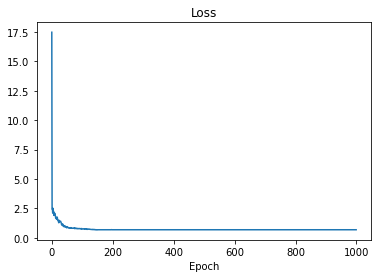

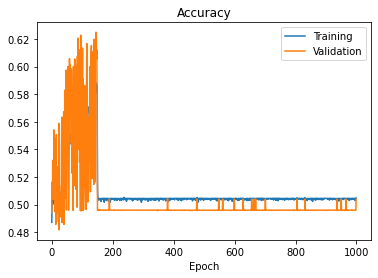

In [137]:
#print(history.history)

plt.clf()
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

plt.clf()
plt.plot(history.history['accuracy'], label = 'Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [138]:
# Make predictions for a different observation
cas_A = pd.read_csv(file_dir+'science_dataframe_1505.csv').dropna()
print(cas_A)

Xs = np.array(cas_A[feature_list].values)

predict_cas_A = model.predict(Xs)

         Unnamed: 0          time  crsv  crsu  amp_sf  av1   av2  av3  au1  \
0                 0  6.196317e+07    31    33       1  102   501   46   42   
1                 1  6.196317e+07    22    27       1   50   433   81   42   
2                 2  6.196318e+07    47    13       1  204   612   57  288   
3                 3  6.196318e+07    40    33       1  193   852   75  422   
4                 4  6.196318e+07     2    21       1  394   542   22   55   
...             ...           ...   ...   ...     ...  ...   ...  ...  ...   
6951805     6951805  6.201342e+07    29    31       1  314  1147   70  192   
6951806     6951806  6.201342e+07    16    57       1  192   409   28   90   
6951807     6951807  6.201342e+07    28    30       1  264  1744  148  492   
6951808     6951808  6.201342e+07    57    56       1  325   487  217   89   
6951809     6951809  6.201342e+07    32    20       1  290   416   29  265   

          au2  ...  PI exceeding 255  Event time tag is out of 

~~~~~~~~Length of background =  0
~~~~~~~~Length of sources =  6900503


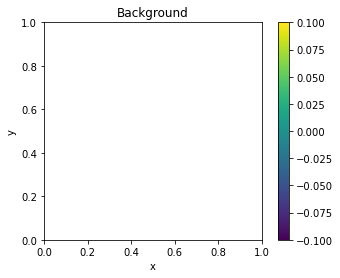

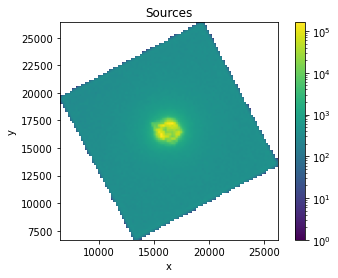

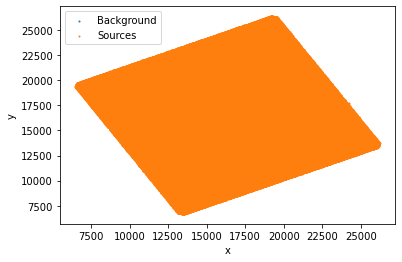

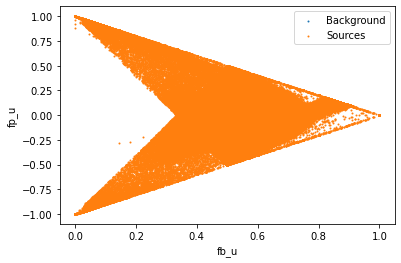

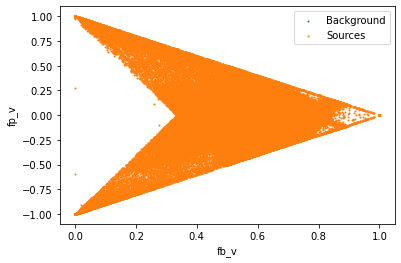

/Users/beckynevin/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


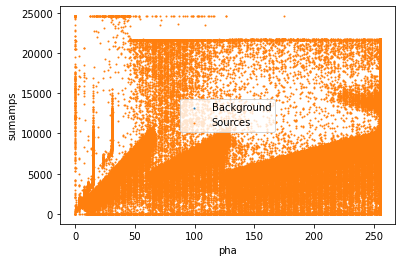

In [139]:
cas_A['prediction'] = predict_cas_A


df1 = cas_A[cas_A['prediction'] > 0.5]
df2 = cas_A[cas_A['prediction'] < 0.5]

compare_in_parameter_space(param_list, df1, df2)

In [ ]:
# Make predictions on the entire dataset

In [3]:
# This is the good ol bagging method, the random forest is probably more relevant here
nbins=300
rad=100000
predictor_list_in = ['fb_u','fp_u','fb_v','fp_v','pha','sumamps']
predictor_list_in_RFR = ['fb_u','fp_u','fb_v','fp_v','pha','sumamps','random']

n_est = 100
max_samp = 'balance'
len_feat = len(predictor_list_in)

# n_estimators, max_samples, len_features = bagging_hyperaparameters

#['1505','144','9219','591','20741','1483']

predictor_list_in = ['fb_u','fp_u','fb_v','fp_v','pha','sumamps']
predictor_list_in_RFR = ['fb_u','fp_u','fb_v','fp_v','pha','sumamps','random']
len_feat = len(predictor_list_in)

csv_path = "/Users/beckynevin/CfA_Code/EVE/data/csv_files/"

preds_sci_RFR, preds_bg_RFR, pred_sci_bag, pred_bg_bag, sci_set, bg_set = classify_cutout_stars(csv_path,'579','1505',#train, test 
                                                                             rad, nbins,#use 1000 for Cas A
                                                                             int(4e5),#subsample size
                                                                            int(4e3),# number of positives ie background
                                                                             0.5,
                                                                            [n_est, max_samp, len_feat],
                                                                            predictor_list_in,
                                                                            predictor_list_in_RFR,
                                                                                True, #plot_data
                                                                                False,#run_hyperbola
                                                                                False,#run_forest
                                                                                False,#balanced
                                                                                False,
                                                                                adjust_th = True)

# order is sci, bg train, sci, bg test

/Users/beckynevin/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


ValueError: Cannot take a larger sample than population when 'replace=False'

In [4]:
# Start working on writing a neural network (supervised)